# statistical analysis of inference results

In [1]:
import sys
import os
current_dir = os.path.abspath('')
os.chdir(current_dir)
sys.path.append(os.path.join(current_dir,'..','code','BalancingControl'))

import two_stage_utils as tu
import inference as inf
import inference_utils as iu

torch threads 1
Running on device cpu
torch threads 1


In [2]:
import torch
import pyro

import os
from scipy.io import loadmat
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
import json
import gc

### Folder and file settings

In [3]:
results_folder = "results"
inference_folder = os.path.join(results_folder, "inference")

mask_file_name = "mask.txt"
processed_data_folder = os.path.join("processed_data")
mask_file = os.path.join(processed_data_folder, mask_file_name)

processed_data_folder = os.path.join("processed_data")

full_data_fname = "full_data.csv"
full_data_file = os.path.join(processed_data_folder, full_data_fname)

full_data_df = pd.read_csv(full_data_file)

statistics_folder = os.path.join(results_folder, "statistics")

scores_file_name = "scores.csv"
scores_file = os.path.join(statistics_folder, scores_file_name)

n_agents = 188

### Experiment parameters

In [4]:
trials =  201#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
# prob for invalid answer (e.g. no reply). Same frequency as in the real data
with open(mask_file, "rb") as f:
    all_mask = pickle.load(f)
# simulations will be done with the same missing actions as in the data.
exp_mask = torch.tensor(all_mask).permute((1,0))
p_valid = exp_mask.sum()/(exp_mask.shape[0]*exp_mask.shape[1])
print(p_valid)

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_valid, "mask": exp_mask}

tensor(0.9766)


/tmp/ipykernel_127610/1548601007.py:16: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  exp_mask = torch.tensor(all_mask).permute((1,0))


In [5]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

### Convenience functions

In [6]:
def convert_data_for_agent(full_data_df):

    mask = full_data_df.loc[(full_data_df["step_index"]==1)]
    mask_formatted = torch.stack([torch.from_numpy(mask.loc[mask["subject"]==i]["mask"].to_numpy()) for i in range(n_agents)])

    actions1 = full_data_df.loc[(full_data_df["step_index"]==1)]
    actions1_formatted = torch.stack([torch.from_numpy(actions1.loc[actions1["subject"]==i]["first_stage_actions"].to_numpy()) for i in range(n_agents)])

    actions2 = full_data_df.loc[(full_data_df["step_index"]==2)]
    actions2_formatted = torch.stack([torch.from_numpy(actions2.loc[actions2["subject"]==i]["second_stage_actions"].to_numpy()) for i in range(n_agents)])

    print("possible actions1", torch.unique(actions1_formatted[mask_formatted]))
    print("possible actions2", torch.unique(actions2_formatted[mask_formatted]))

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    actions1_formatted = torch.where(mask_formatted, actions1_formatted, -1)
    actions2_formatted = torch.where(mask_formatted, actions2_formatted, -1)

    actions = torch.stack([actions1_formatted, actions2_formatted], dim=-1).permute((1,2,0))
    #print(actions.permute((0,2,1))[mask_formatted])
    # agent counts from zero:
    actions = actions-1.

    states1 = full_data_df.loc[(full_data_df["step_index"]==1)]
    # agent counts from zero, hence -1 at the end:
    states1_formatted = torch.stack([torch.from_numpy(states1.loc[states1["subject"]==i]["first_stage_states"].to_numpy()) for i in range(n_agents)]) - 1
     
    states2 = full_data_df.loc[(full_data_df["step_index"]==2)]
    # agent counts from zero, hence -1 at the end:
    states2_formatted = torch.stack([torch.from_numpy(states2.loc[states2["subject"]==i]["second_stage_states"].to_numpy()) for i in range(n_agents)]) - 1

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    states1_formatted = torch.where(mask_formatted, states1_formatted, -1)
    states2_formatted = torch.where(mask_formatted, states2_formatted, -1)
    # create third time step states:
    states3_formatted = states2_formatted+2 + (actions2_formatted-1)*2
    states3_formatted = torch.where(mask_formatted, states3_formatted, -1)


    print("possible states1", torch.unique(states1_formatted[mask_formatted]))
    print("possible states2", torch.unique(states2_formatted[mask_formatted]))
    print("possible states3", torch.unique(states3_formatted[mask_formatted]))

    states = torch.stack([states1_formatted, states2_formatted, states3_formatted], dim=-1).permute((1,2,0))

    # agent views r=2 as "no reward", may instead give negative reward as in Otto et al:
    rewards1_formatted = torch.zeros_like(states1_formatted) #+ 2

    rewards2_formatted = rewards1_formatted

    # create third time step rewards = second stage rewards:
    rewards3 = full_data_df.loc[(full_data_df["step_index"]==2)]
    rewards3_formatted = torch.stack([torch.from_numpy(rewards3.loc[rewards3["subject"]==i]["second_stage_rewards"].to_numpy()) for i in range(n_agents)])

    print("possible rewards1", torch.unique(rewards1_formatted[mask_formatted]))
    print("possible rewards2", torch.unique(rewards2_formatted[mask_formatted]))
    print("possible rewards3", torch.unique(rewards3_formatted[mask_formatted]))

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    rewards1_formatted = torch.where(mask_formatted, rewards1_formatted, 0)
    rewards2_formatted = torch.where(mask_formatted, rewards2_formatted, 0)
    rewards3_formatted = torch.where(mask_formatted, rewards3_formatted, 0)

    rewards = torch.stack([rewards1_formatted, rewards2_formatted, rewards3_formatted], dim=-1).permute((1,2,0))


    data_dict = {"observations": states.long(), "rewards": rewards.long(), "actions": actions.long(), "valid": mask_formatted.permute((1,0))}

    return data_dict

data = convert_data_for_agent(full_data_df)

print(data)

possible actions1 tensor([1., 2.], dtype=torch.float64)
possible actions2 tensor([1., 2.], dtype=torch.float64)
possible states1 tensor([0.], dtype=torch.float64)
possible states2 tensor([1., 2.], dtype=torch.float64)
possible states3 tensor([3., 4., 5., 6.], dtype=torch.float64)
possible rewards1 tensor([0.], dtype=torch.float64)
possible rewards2 tensor([0.], dtype=torch.float64)
possible rewards3 tensor([0., 1.], dtype=torch.float64)
{'observations': tensor([[[ 0,  0,  0,  ..., -1,  0, -1],
         [ 1,  1,  2,  ..., -1,  1, -1],
         [ 3,  3,  4,  ..., -1,  5, -1]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 1,  1,  2,  ...,  1,  1,  2],
         [ 5,  3,  6,  ...,  3,  3,  4]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 1,  1,  2,  ...,  2,  2,  1],
         [ 5,  3,  6,  ...,  6,  6,  3]],

        ...,

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 1,  1,  2,  ...,  1,  2,  1],
         [ 3,  5,  4,  ...,  3,  6,  3]],

        [[ 0,  0, -1,  ..., 

In [7]:
def load_BCC_results(learn_rewards, learn_habit, learn_cached, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names, use_h=False):    

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, learn_rewards, learn_habit, learn_cached, base_dir, 
                                                    global_experiment_parameters, data["valid"], remove_old=False, 
                                                    use_h=use_h)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_sample_df = iu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_sample_df = iu.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_sample_df

In [8]:
def load_MFMB_results(use_orig, learn_prior, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, valid, fname_base, num_steps, data, param_names):    

    # set up agent
    mfmb_agent = tu.set_up_mbmf_inference_agent(n_agents, learn_prior, use_orig, use_p, restrict_alpha, max_dt, 0, base_dir, global_experiment_parameters, valid, remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = False

    # set up inference
    inferrer = inf.GeneralGroupInference(mfmb_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_sample_df = iu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_sample_df = iu.load_samples(base_dir, fname_str) 

    return mean_df, sample_df, locs_sample_df

### load behavioral outputs of participants: mf-/mb-scores

In [9]:
scores_df = pd.read_csv(scores_file)

### Load BCC4 planning+repetition results, and plot correlations between inferred parameters

BCC_4pars_plan_habit_weight_NO_context
BCC_4pars_plan_habit_weight_NO_context_inference_
4
analyzing 188 data sets


/home/sarah/src/TwoStageStrategies/Chen_et_al_data/../code/BalancingControl/perception.py:136: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch-select_1707782759820/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


<Figure size 640x480 with 0 Axes>

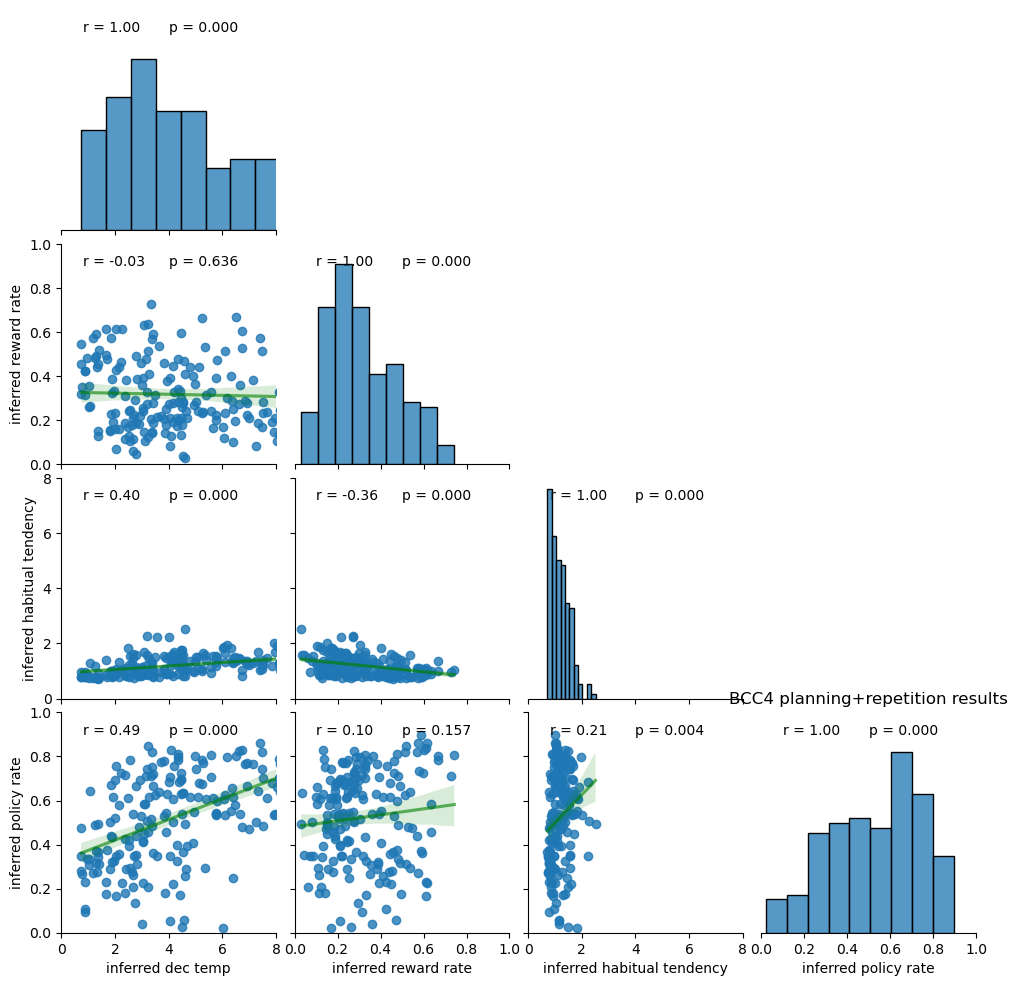

In [10]:
# BCC4 planning repetition analysis

learn_rewards = True
learn_habit = True
use_h = False
learn_cached = False

param_names = []
param_ranges = []

prefix = "BCC"
model_name = "Bayesian prior-based contextual control model"
n_pars = 0
agnt_str = ""

if learn_rewards:
    n_pars += 2
    param_names += ["dec temp", "reward rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_plan"

if learn_habit:
    # infer_h = True
    # infer_policy_rate = True 
    n_pars += 2
    agnt_str += "_habit"
    param_names += ["habitual tendency", "policy rate"]
    if use_h:
        agnt_str += "_h"
        param_ranges += [[0,1], [0,1]]
    else:
        agnt_str += "_weight"
        param_ranges += [[0,8], [0,1]]
# else:
#     infer_h = False
#     infer_policy_rate = False

if learn_cached:
    n_pars += 2
    param_names += ["cached weight", "cached rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_cached"

assert n_pars > 0, "please turn any part of the agent on, it cannot run without any learning or inference."

# choose max decision temperature for numerical stability
max_dt = 6

BCC4_p_r_param_names = param_names.copy()
BCC4_p_r_param_ranges = param_ranges.copy()

# prepare for saving results
# make base filename and folder string
agent_type = prefix+"_"+str(n_pars)+"pars"+agnt_str+"_NO_context"
print(agent_type)

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC4_p_r_mean_df, BCC4_p_r_sample_df, BCC4_p_r_locs_df = load_BCC_results(learn_rewards, learn_habit, learn_cached, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names, use_h=False)

# param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC4_p_r_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_ranges):
    f.axes[n_pars-1,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC4 planning+repetition results")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

### BCC4 planning+repetition results: plot correlations with behavioral outputs: mf-/mb-scores

['inferred dec temp BCC4_p_r', 'inferred reward rate BCC4_p_r', 'inferred habitual tendency BCC4_p_r', 'inferred policy rate BCC4_p_r']


<Figure size 640x480 with 0 Axes>

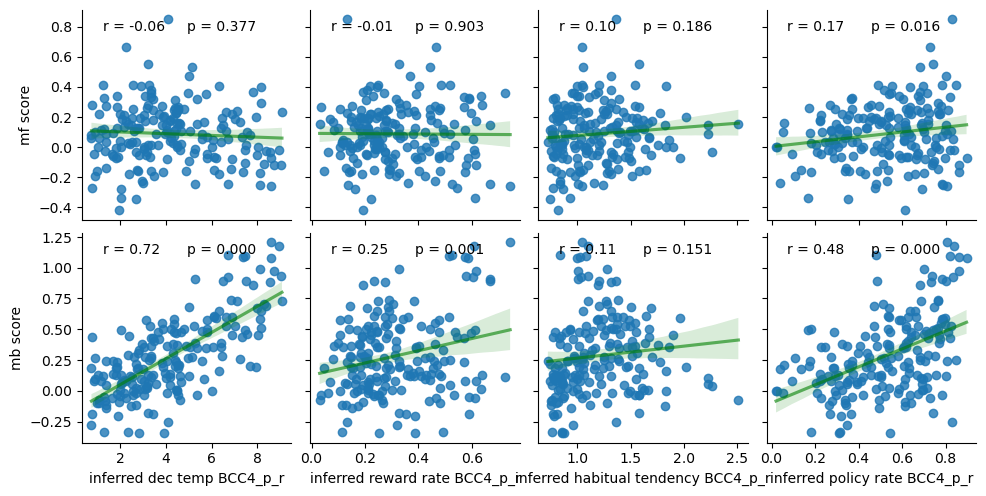

In [11]:
# BCC4 planning repetition

concat_keys_BCC4_p_r = [name+" BCC4_p_r" for name in BCC4_p_r_mean_df.keys()]

new_name_dict_BCC4_p_r = {BCC4_p_r_mean_df.keys()[i]: concat_keys_BCC4_p_r[i] for i in range(len(concat_keys_BCC4_p_r))}

renamed_BCC4_p_r = BCC4_p_r_mean_df.rename(columns=new_name_dict_BCC4_p_r)

BCC4_p_r_scores_df = pd.concat([renamed_BCC4_p_r, scores_df], axis='columns')#, join="inner")

plt.figure()
x_vars_of_interest = ["inferred "+name+" BCC4_p_r" for name in param_names]
print(x_vars_of_interest)
y_vars_of_interest = ["mf score", "mb score"]
f = sns.pairplot(data=BCC4_p_r_scores_df, kind='reg', #diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=x_vars_of_interest, y_vars=y_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[2,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("BCC3 analysis 1 correlations with scores")
plt.savefig(os.path.join(results_folder, "BCC4_planning_repetition_correlations_with_scores.svg"))
plt.show()

### Load BCC4 planning+cached results, and plot correlations between inferred parameters

BCC_4pars_plan_cached_NO_context
BCC_4pars_plan_cached_NO_context_inference_
4
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

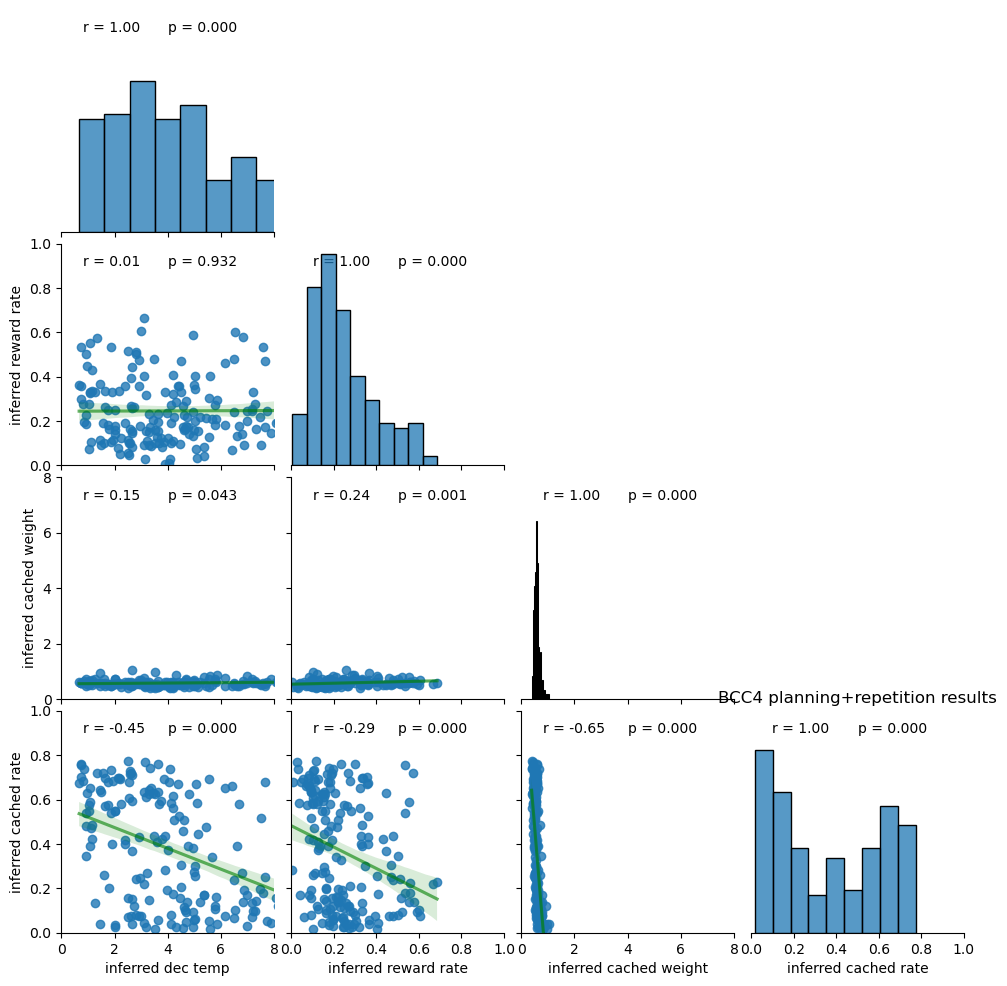

In [12]:
# BCC4 planning repetition analysis

learn_rewards = True
learn_habit = False
use_h = False
learn_cached = True

param_names = []
param_ranges = []

prefix = "BCC"
model_name = "Bayesian prior-based contextual control model"
n_pars = 0
agnt_str = ""

if learn_rewards:
    n_pars += 2
    param_names += ["dec temp", "reward rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_plan"

if learn_habit:
    # infer_h = True
    # infer_policy_rate = True 
    n_pars += 2
    agnt_str += "_habit"
    param_names += ["habitual tendency", "policy rate"]
    if use_h:
        agnt_str += "_h"
        param_ranges += [[0,1], [0,1]]
    else:
        agnt_str += "_weight"
        param_ranges += [[0,8], [0,1]]
# else:
#     infer_h = False
#     infer_policy_rate = False

if learn_cached:
    n_pars += 2
    param_names += ["cached weight", "cached rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_cached"

assert n_pars > 0, "please turn any part of the agent on, it cannot run without any learning or inference."

# choose max decision temperature for numerical stability
max_dt = 6

BCC4_p_c_param_names = param_names.copy()
BCC4_p_c_param_ranges = param_ranges.copy()

# prepare for saving results
# make base filename and folder string
agent_type = prefix+"_"+str(n_pars)+"pars"+agnt_str+"_NO_context"
print(agent_type)

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC4_p_c_mean_df, BCC4_p_c_sample_df, BCC4_p_c_locs_df = load_BCC_results(learn_rewards, learn_habit, learn_cached, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names, use_h=False)

# param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC4_p_c_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_ranges):
    f.axes[n_pars-1,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC4 planning+repetition results")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

### BCC4 planning+cached results: plot correlations with behavioral outputs: mf-/mb-scores

['inferred dec temp BCC4_p_c', 'inferred reward rate BCC4_p_c', 'inferred cached weight BCC4_p_c', 'inferred cached rate BCC4_p_c']


<Figure size 640x480 with 0 Axes>

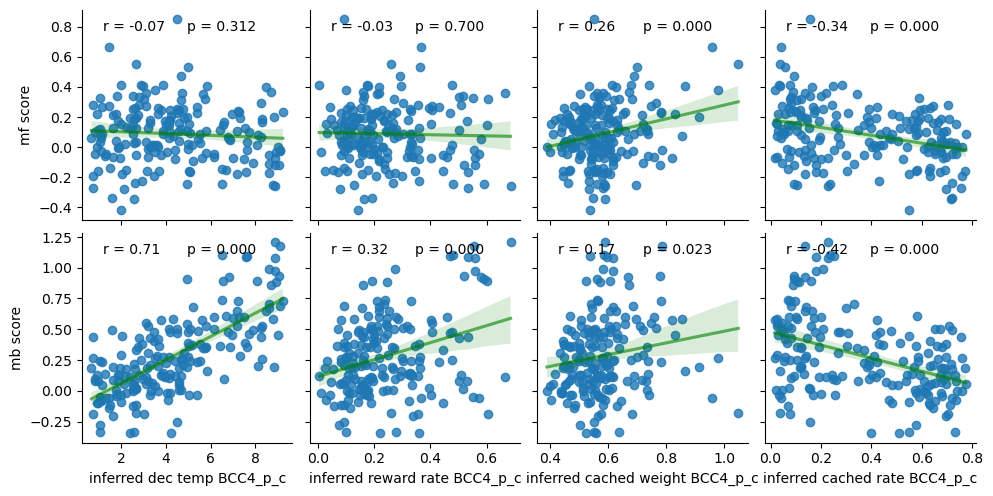

In [13]:
# BCC4 planning repetition

concat_keys_BCC4_p_c = [name+" BCC4_p_c" for name in BCC4_p_c_mean_df.keys()]

new_name_dict_BCC4_p_c = {BCC4_p_c_mean_df.keys()[i]: concat_keys_BCC4_p_c[i] for i in range(len(concat_keys_BCC4_p_c))}

renamed_BCC4_p_c = BCC4_p_c_mean_df.rename(columns=new_name_dict_BCC4_p_c)

BCC4_p_c_scores_df = pd.concat([renamed_BCC4_p_c, scores_df], axis='columns')#, join="inner")

plt.figure()
x_vars_of_interest = ["inferred "+name+" BCC4_p_c" for name in param_names]
print(x_vars_of_interest)
y_vars_of_interest = ["mf score", "mb score"]
f = sns.pairplot(data=BCC4_p_c_scores_df, kind='reg', #diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=x_vars_of_interest, y_vars=y_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[2,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("BCC3 analysis 1 correlations with scores")
plt.savefig(os.path.join(results_folder, "BCC4_planning_repetition_correlations_with_scores.svg"))
plt.show()

### Load BCC6 planning+repetition+cached results, and plot correlations between inferred parameters

BCC_6pars_plan_habit_weight_cached_NO_context
BCC_6pars_plan_habit_weight_cached_NO_context_inference_
6
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

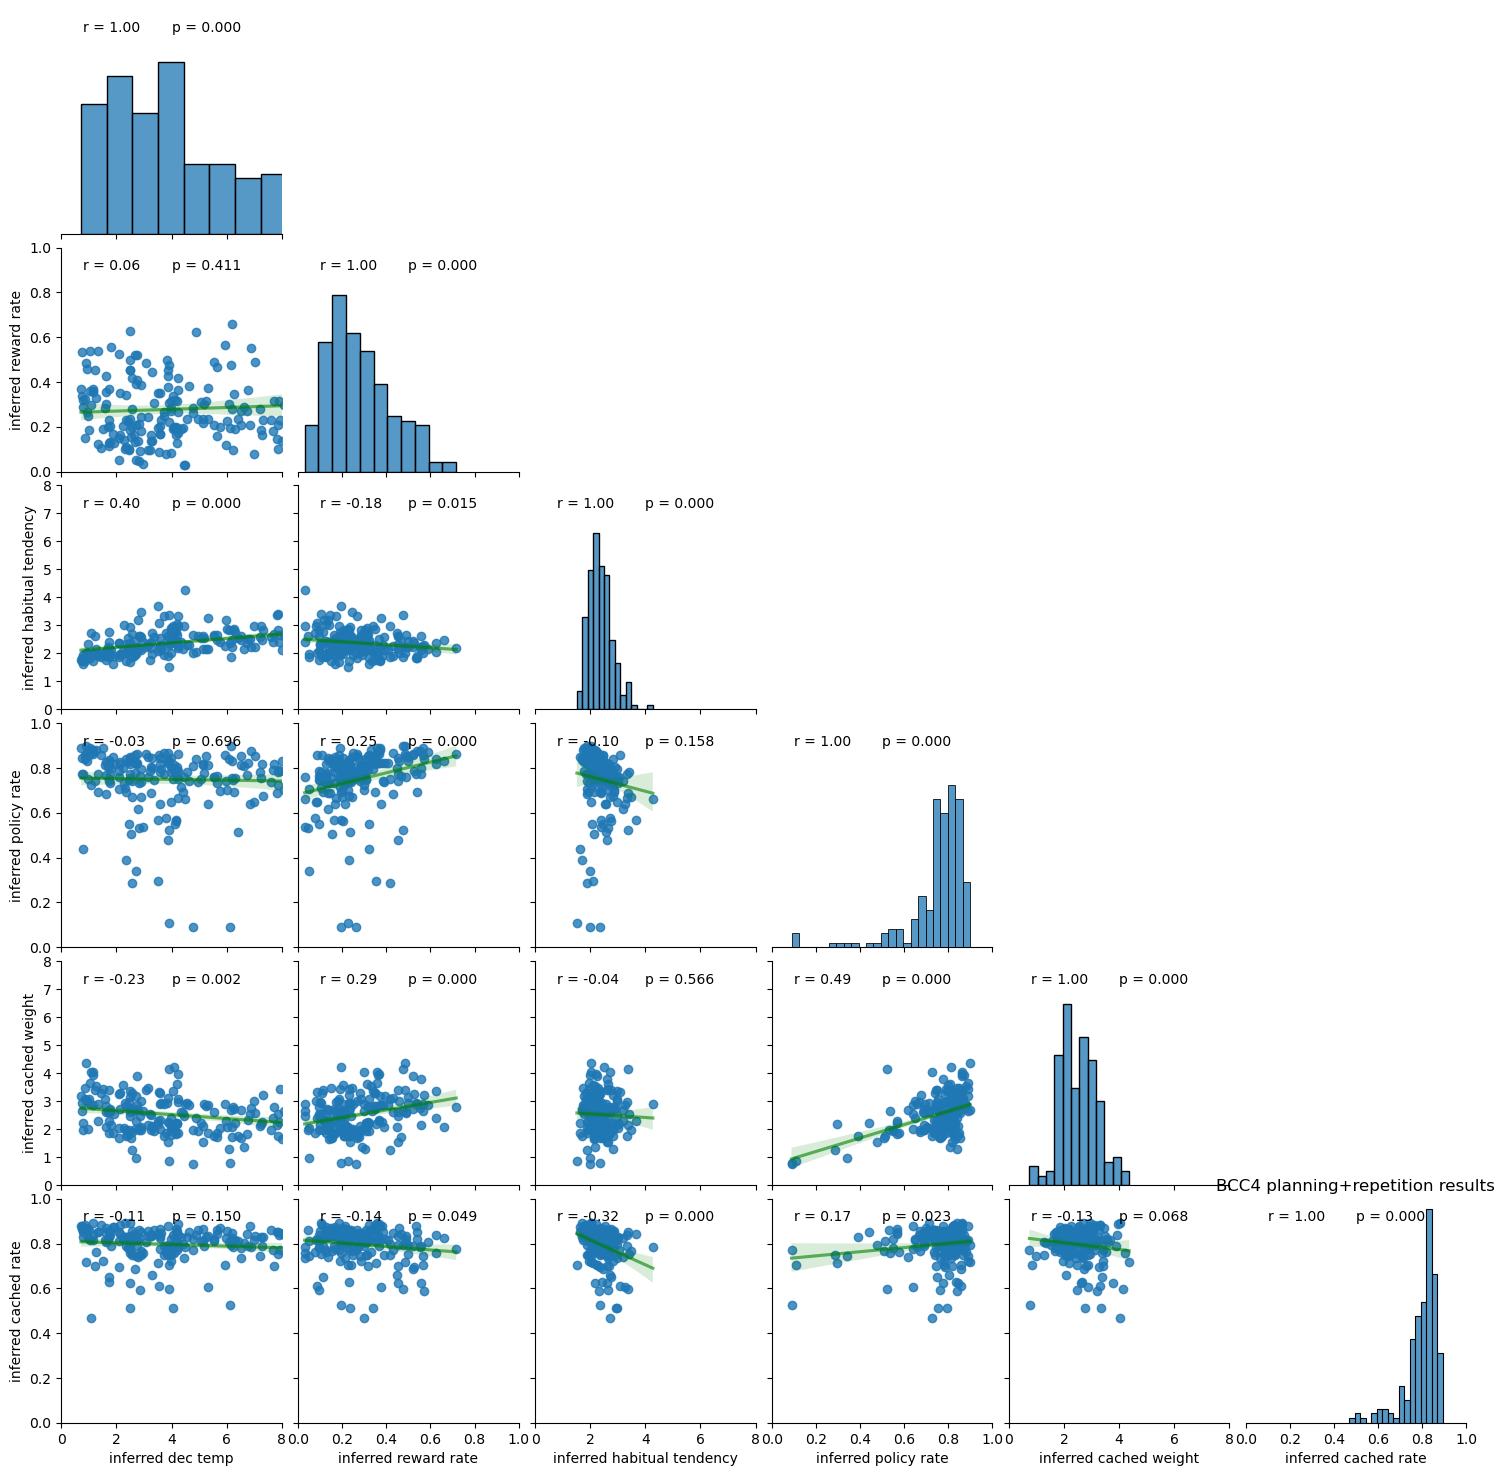

In [14]:
# BCC4 planning repetition analysis

learn_rewards = True
learn_habit = True
use_h = False
learn_cached = True

param_names = []
param_ranges = []

prefix = "BCC"
model_name = "Bayesian prior-based contextual control model"
n_pars = 0
agnt_str = ""

if learn_rewards:
    n_pars += 2
    param_names += ["dec temp", "reward rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_plan"

if learn_habit:
    # infer_h = True
    # infer_policy_rate = True 
    n_pars += 2
    agnt_str += "_habit"
    param_names += ["habitual tendency", "policy rate"]
    if use_h:
        agnt_str += "_h"
        param_ranges += [[0,1], [0,1]]
    else:
        agnt_str += "_weight"
        param_ranges += [[0,8], [0,1]]
# else:
#     infer_h = False
#     infer_policy_rate = False

if learn_cached:
    n_pars += 2
    param_names += ["cached weight", "cached rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_cached"

assert n_pars > 0, "please turn any part of the agent on, it cannot run without any learning or inference."

# choose max decision temperature for numerical stability
max_dt = 6

BCC6_param_names = param_names.copy()
BCC6_param_ranges = param_ranges.copy()

# prepare for saving results
# make base filename and folder string
agent_type = prefix+"_"+str(n_pars)+"pars"+agnt_str+"_NO_context"
print(agent_type)

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

BCC6_mean_df, BCC6_sample_df, BCC6_locs_df = load_BCC_results(learn_rewards, learn_habit, learn_cached, base_dir, global_experiment_parameters, exp_mask, fname_base, num_steps, data, param_names, use_h=False)

# param_plot_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=BCC6_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_ranges):
    f.axes[n_pars-1,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("BCC4 planning+repetition results")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()

### BCC6 planning+repetition+cached results: plot correlations with behavioral outputs: mf-/mb-scores

['inferred dec temp BCC6', 'inferred reward rate BCC6', 'inferred habitual tendency BCC6', 'inferred policy rate BCC6', 'inferred cached weight BCC6', 'inferred cached rate BCC6']


<Figure size 640x480 with 0 Axes>

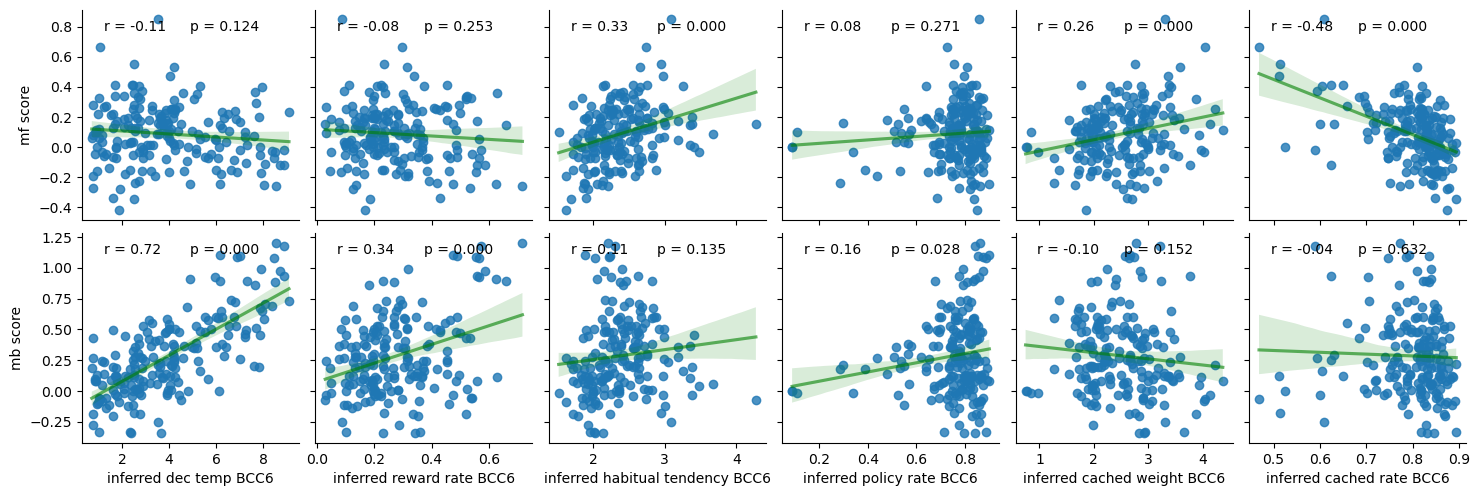

In [15]:
# BCC6

concat_keys_BCC6 = [name+" BCC6" for name in BCC6_mean_df.keys()]

new_name_dict_BCC6 = {BCC6_mean_df.keys()[i]: concat_keys_BCC6[i] for i in range(len(concat_keys_BCC6))}

renamed_BCC6 = BCC6_mean_df.rename(columns=new_name_dict_BCC6)

BCC6_scores_df = pd.concat([renamed_BCC6, scores_df], axis='columns')#, join="inner")

plt.figure()
x_vars_of_interest = ["inferred "+name+" BCC6" for name in param_names]
print(x_vars_of_interest)
y_vars_of_interest = ["mf score", "mb score"]
f = sns.pairplot(data=BCC6_scores_df, kind='reg', #diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=x_vars_of_interest, y_vars=y_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[2,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("BCC3 analysis 1 correlations with scores")
plt.savefig(os.path.join(results_folder, "BCC4_planning_repetition_correlations_with_scores.svg"))
plt.show()

### Sanity check: did the BCC6 and BCC4 planning+repetition analyses yield consistent results in the parameters they share?

Plotting correlations between inferred parameters of the two analyses

Index(['Unnamed: 0 BCC4_p_r', 'inferred dec temp BCC4_p_r', 'subject BCC4_p_r',
       'inferred reward rate BCC4_p_r', 'inferred habitual tendency BCC4_p_r',
       'inferred policy rate BCC4_p_r', 'Unnamed: 0 BCC6',
       'inferred dec temp BCC6', 'subject BCC6', 'inferred reward rate BCC6',
       'inferred habitual tendency BCC6', 'inferred policy rate BCC6',
       'inferred cached weight BCC6', 'inferred cached rate BCC6'],
      dtype='object')
['Unnamed: 0 BCC4_p_r', 'inferred dec temp BCC4_p_r', 'subject BCC4_p_r', 'inferred reward rate BCC4_p_r', 'inferred habitual tendency BCC4_p_r', 'inferred policy rate BCC4_p_r']
['Unnamed: 0 BCC6', 'inferred dec temp BCC6', 'subject BCC6', 'inferred reward rate BCC6', 'inferred habitual tendency BCC6', 'inferred policy rate BCC6', 'inferred cached weight BCC6', 'inferred cached rate BCC6']
Index(['Unnamed: 0 BCC6', 'inferred dec temp BCC6', 'subject BCC6',
       'inferred reward rate BCC6', 'inferred habitual tendency BCC6',
       'in

<Figure size 640x480 with 0 Axes>

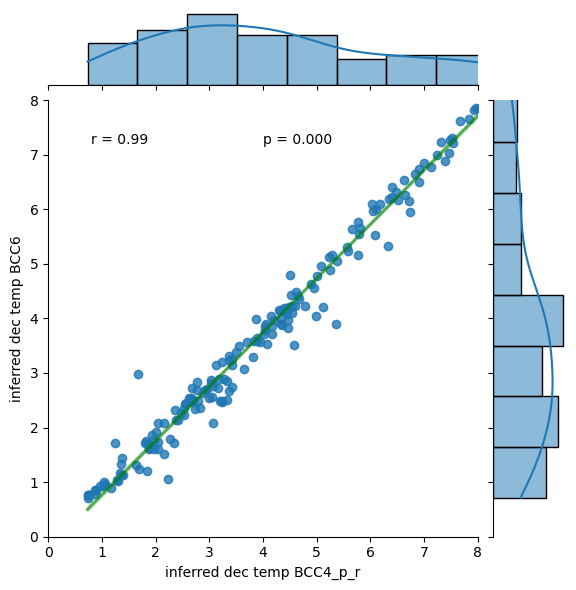

<Figure size 640x480 with 0 Axes>

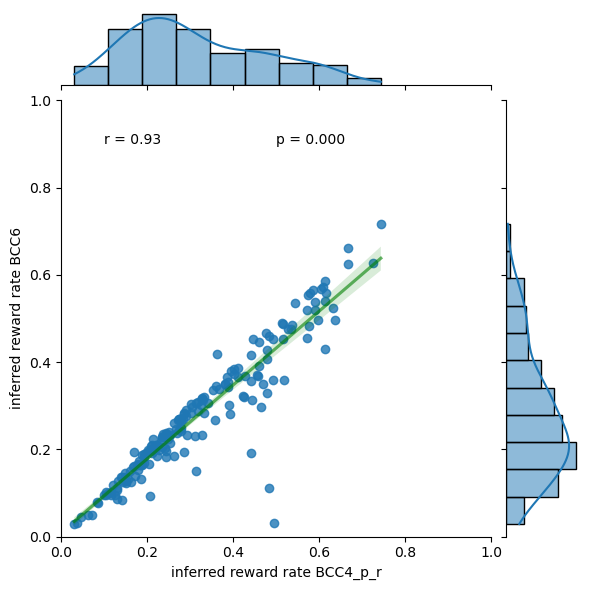

<Figure size 640x480 with 0 Axes>

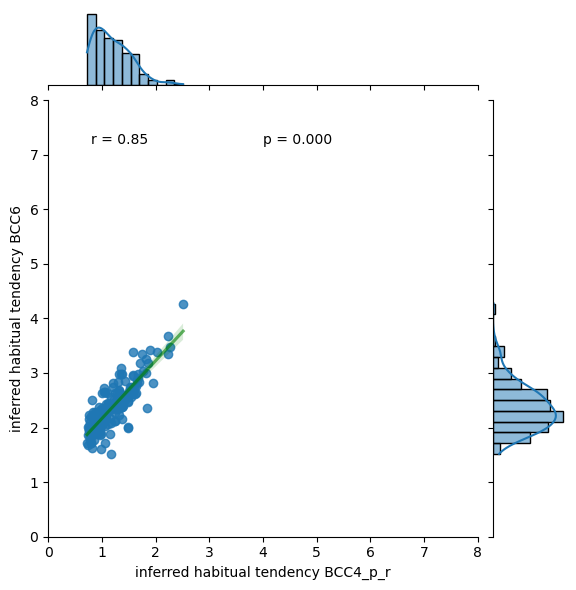

<Figure size 640x480 with 0 Axes>

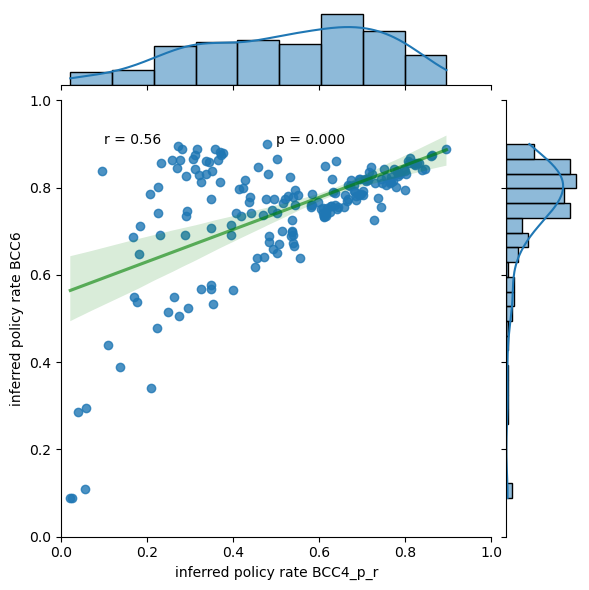

In [16]:
# compare the two results

concat_keys_BCC4_p_r = [name+" BCC4_p_r" for name in BCC4_p_r_mean_df.keys()]
concat_keys_BCC6 = [name+" BCC6" for name in BCC6_mean_df.keys()]

new_name_dict_BCC4_p_r = {BCC4_p_r_mean_df.keys()[i]: concat_keys_BCC4_p_r[i] for i in range(len(concat_keys_BCC4_p_r))}
new_name_dict_BCC6 = {BCC6_mean_df.keys()[i]: concat_keys_BCC6[i] for i in range(len(concat_keys_BCC6))}

renamed_BCC4_p_r = BCC4_p_r_mean_df.rename(columns=new_name_dict_BCC4_p_r)
renamed_BCC6 = BCC6_mean_df.rename(columns=new_name_dict_BCC6)

BCC_means_df = pd.concat([renamed_BCC4_p_r, renamed_BCC6], axis='columns')#, join="inner")

print(BCC_means_df.keys())

print(concat_keys_BCC4_p_r)
print(concat_keys_BCC6)
print(renamed_BCC6.keys())

BCC4_p_r_vars_of_interest = ["inferred "+name+" BCC4_p_r" for name in BCC4_p_r_param_names]
BCC6_vars_of_interest = ["inferred "+name+" BCC6" for name in BCC6_param_names]

#plt.figure()
##sns.relplot(data=BCC3_means_df, )
#sns.pairplot(data=BCC3_means_df, x_vars=a1_vars_of_interest, y_vars=a2_vars_of_interest)#, x_vars = )
#plt.show()

for i, name in enumerate(BCC4_p_r_param_names):
    plt.figure()
    #sns.scatterplot(data=BCC3_means_df, x="inferred "+name+" analysis 1", y="inferred "+name+" analysis 2")
    f = sns.jointplot(data=BCC_means_df, x="inferred "+name+" BCC4_p_r", y="inferred "+name+" BCC6", 
                  kind='reg', joint_kws={'line_kws': {'color': 'green', 'alpha': 0.6}})
    tu.annot_corrfunc(BCC_means_df["inferred "+name+" BCC4_p_r"], BCC_means_df["inferred "+name+" BCC6"])
    plt.xlim(BCC4_p_r_param_ranges[i])
    plt.ylim(BCC4_p_r_param_ranges[i])
    #plt.title("inferred "+name+" BCC3 + inferred "+name+" BCC4")
    plt.show()

#for i, name in enumerate(BCC_param_names[:-1]):
#    plt.figure()
#    #sns.scatterplot(data=BCC3_means_df, x="inferred "+name+" analysis 1", y="inferred "+name+" analysis 2")
#    sns.jointplot(data=BCC_means_df, x="inferred "+name+" BCC3", y="inferred habitual tendency BCC4")
#    plt.xlim(param_ranges[i])
#    #plt.ylim(param_ranges[i])
#    plt.show()

### Sanity check: did the BCC6 and BCC4 planning+cached analyses yield consistent results in the parameters they share?

Plotting correlations between inferred parameters of the two analyses

Index(['Unnamed: 0 BCC4_p_c', 'inferred dec temp BCC4_p_c', 'subject BCC4_p_c',
       'inferred reward rate BCC4_p_c', 'inferred cached weight BCC4_p_c',
       'inferred cached rate BCC4_p_c', 'Unnamed: 0 BCC6',
       'inferred dec temp BCC6', 'subject BCC6', 'inferred reward rate BCC6',
       'inferred habitual tendency BCC6', 'inferred policy rate BCC6',
       'inferred cached weight BCC6', 'inferred cached rate BCC6'],
      dtype='object')
['Unnamed: 0 BCC4_p_c', 'inferred dec temp BCC4_p_c', 'subject BCC4_p_c', 'inferred reward rate BCC4_p_c', 'inferred cached weight BCC4_p_c', 'inferred cached rate BCC4_p_c']
['Unnamed: 0 BCC6', 'inferred dec temp BCC6', 'subject BCC6', 'inferred reward rate BCC6', 'inferred habitual tendency BCC6', 'inferred policy rate BCC6', 'inferred cached weight BCC6', 'inferred cached rate BCC6']
Index(['Unnamed: 0 BCC6', 'inferred dec temp BCC6', 'subject BCC6',
       'inferred reward rate BCC6', 'inferred habitual tendency BCC6',
       'inferred p

<Figure size 640x480 with 0 Axes>

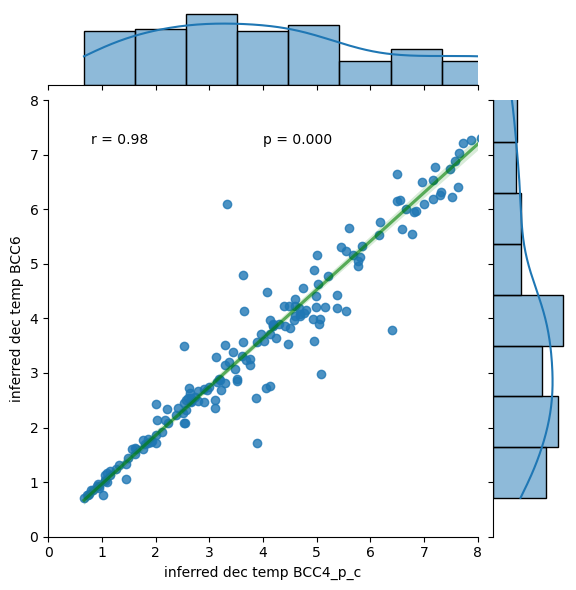

<Figure size 640x480 with 0 Axes>

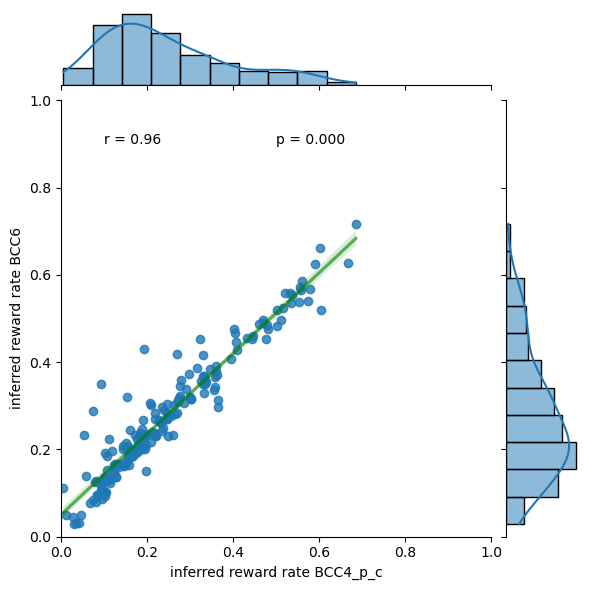

<Figure size 640x480 with 0 Axes>

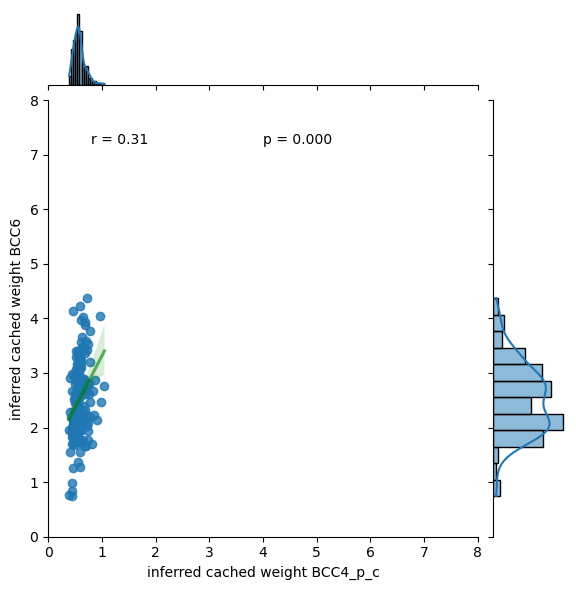

<Figure size 640x480 with 0 Axes>

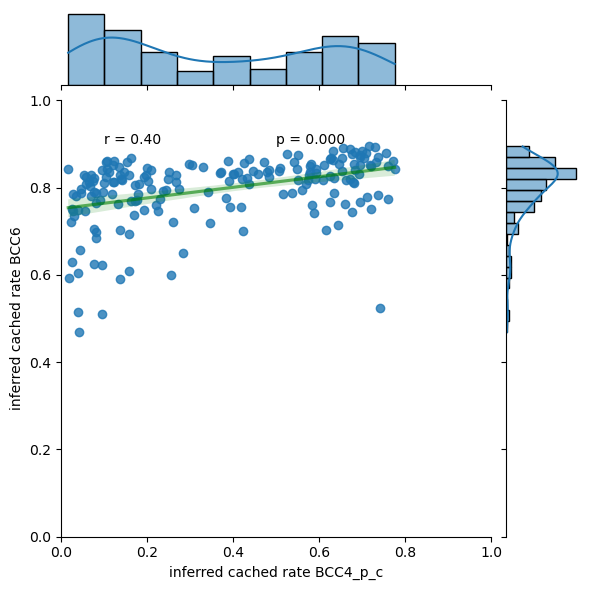

In [17]:
# compare the two results

concat_keys_BCC4_p_c = [name+" BCC4_p_c" for name in BCC4_p_c_mean_df.keys()]
concat_keys_BCC6 = [name+" BCC6" for name in BCC6_mean_df.keys()]

new_name_dict_BCC4_p_c = {BCC4_p_c_mean_df.keys()[i]: concat_keys_BCC4_p_c[i] for i in range(len(concat_keys_BCC4_p_c))}
new_name_dict_BCC6 = {BCC6_mean_df.keys()[i]: concat_keys_BCC6[i] for i in range(len(concat_keys_BCC6))}

renamed_BCC4_p_c = BCC4_p_c_mean_df.rename(columns=new_name_dict_BCC4_p_c)
renamed_BCC6 = BCC6_mean_df.rename(columns=new_name_dict_BCC6)

BCC_means_df = pd.concat([renamed_BCC4_p_c, renamed_BCC6], axis='columns')#, join="inner")

print(BCC_means_df.keys())

print(concat_keys_BCC4_p_c)
print(concat_keys_BCC6)
print(renamed_BCC6.keys())

BCC4_p_c_vars_of_interest = ["inferred "+name+" BCC4_p_c" for name in BCC4_p_c_param_names]
BCC6_vars_of_interest = ["inferred "+name+" BCC6" for name in BCC6_param_names]

#plt.figure()
##sns.relplot(data=BCC3_means_df, )
#sns.pairplot(data=BCC3_means_df, x_vars=a1_vars_of_interest, y_vars=a2_vars_of_interest)#, x_vars = )
#plt.show()

for i, name in enumerate(BCC4_p_c_param_names):
    plt.figure()
    #sns.scatterplot(data=BCC3_means_df, x="inferred "+name+" analysis 1", y="inferred "+name+" analysis 2")
    f = sns.jointplot(data=BCC_means_df, x="inferred "+name+" BCC4_p_c", y="inferred "+name+" BCC6", 
                  kind='reg', joint_kws={'line_kws': {'color': 'green', 'alpha': 0.6}})
    tu.annot_corrfunc(BCC_means_df["inferred "+name+" BCC4_p_c"], BCC_means_df["inferred "+name+" BCC6"])
    plt.xlim(BCC4_p_c_param_ranges[i])
    plt.ylim(BCC4_p_c_param_ranges[i])
    #plt.title("inferred "+name+" BCC3 + inferred "+name+" BCC4")
    plt.show()

#for i, name in enumerate(BCC_param_names[:-1]):
#    plt.figure()
#    #sns.scatterplot(data=BCC3_means_df, x="inferred "+name+" analysis 1", y="inferred "+name+" analysis 2")
#    sns.jointplot(data=BCC_means_df, x="inferred "+name+" BCC3", y="inferred habitual tendency BCC4")
#    plt.xlim(param_ranges[i])
#    #plt.ylim(param_ranges[i])
#    plt.show()

### Load MFMB4 analysis, and plot correlations between inferred parameters

mbmf__inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

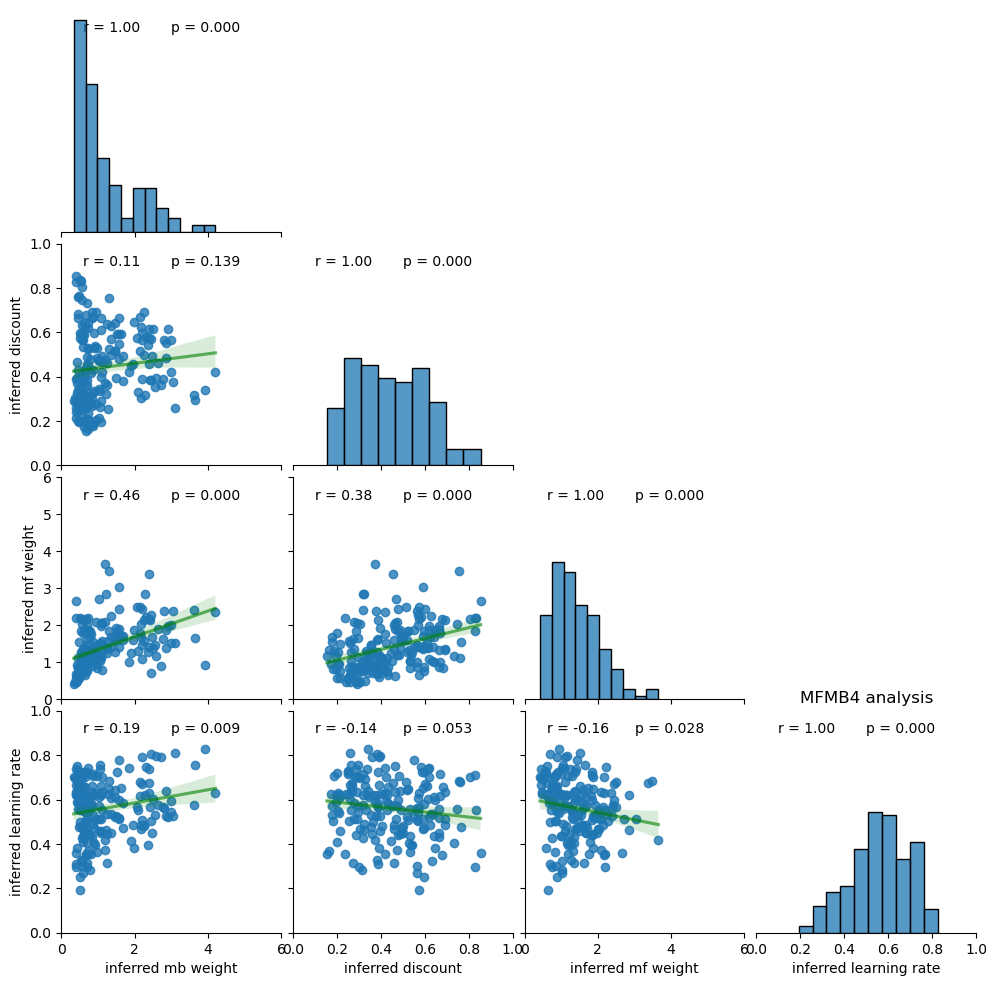

This is inference for the twostage task using the two beta mbmf model(mbmf_) with 188 agents.
The settings are: use p False


In [18]:
# MFMB4 analysis

# set parameters and their names
learn_prior = False

use_orig = False

use_p = False
restrict_alpha = False
max_dt = 6

n_pars = 4

agnt_str = ""

if use_orig:
    agnt_str += "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight"]
    model_name = "original original w and beta model"
    param_ranges = [[0,1], [0,1], [0,8], [0,1]]
else:
    agnt_str += "mbmf_"
    param_names = ["mb weight", "discount", "mf weight", "learning rate"]
    model_name = "two beta mbmf model"
    param_ranges = [[0,max_dt], [0,1], [0,max_dt], [0,1]]


if learn_prior:
    n_pars += 2
    param_names += ["prior lr", "prior weight"]
    param_ranges += [[0,1], [0,max_dt]]
    agnt_str += "_prior"

if use_p:
    n_pars += 1
    agnt_str += "_p"
    param_names += ["repetition"]
    
if restrict_alpha:
    agnt_str += "_resticted"
    min_alpha = 0.1
else:
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = agnt_str

MFMB4_param_names = param_names.copy()
MFMB4_param_ranges = param_ranges.copy()

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

MFMB4_mean_df, MFMB4_sample_df, MFMB4_locs_df = load_MFMB_results(use_orig, learn_prior, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, data["valid"], fname_base, num_steps, data, MFMB4_param_names)

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB4_param_names]
f = sns.pairplot(data=MFMB4_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB4_param_ranges):
    f.axes[n_pars-1,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB4 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: use p", use_p)

### MFMB4: plot correlations with behavioral outputs: mf-/mb-scores

['inferred mb weight MFMB4', 'inferred discount MFMB4', 'inferred mf weight MFMB4', 'inferred learning rate MFMB4']


<Figure size 640x480 with 0 Axes>

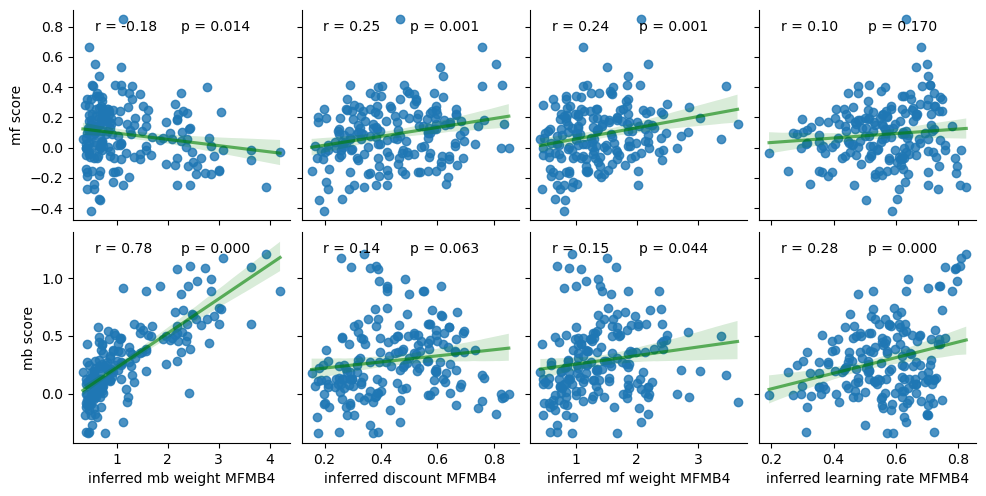

In [19]:
# MFMB4

concat_keys_MFMB4 = [name+" MFMB4" for name in MFMB4_mean_df.keys()]

new_name_dict_MFMB4 = {MFMB4_mean_df.keys()[i]: concat_keys_MFMB4[i] for i in range(len(concat_keys_MFMB4))}

renamed_MFMB4 = MFMB4_mean_df.rename(columns=new_name_dict_MFMB4)

MFMB4_scores_df = pd.concat([renamed_MFMB4, scores_df], axis='columns')#, join="inner")

plt.figure()
x_vars_of_interest = ["inferred "+name+" MFMB4" for name in MFMB4_param_names]
print(x_vars_of_interest)
y_vars_of_interest = ["mf score", "mb score"]
f = sns.pairplot(data=MFMB4_scores_df, kind='reg', #diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=x_vars_of_interest, y_vars=y_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[2,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("BCC3 analysis 1 correlations with scores")
plt.savefig(os.path.join(results_folder, "MFMB4_correlations_with_scores.svg"))
plt.show()

### Load MFMB6 analysis, and plot correlations between inferred parameters

mbmf__prior_inference_
analyzing 188 data sets


<Figure size 640x480 with 0 Axes>

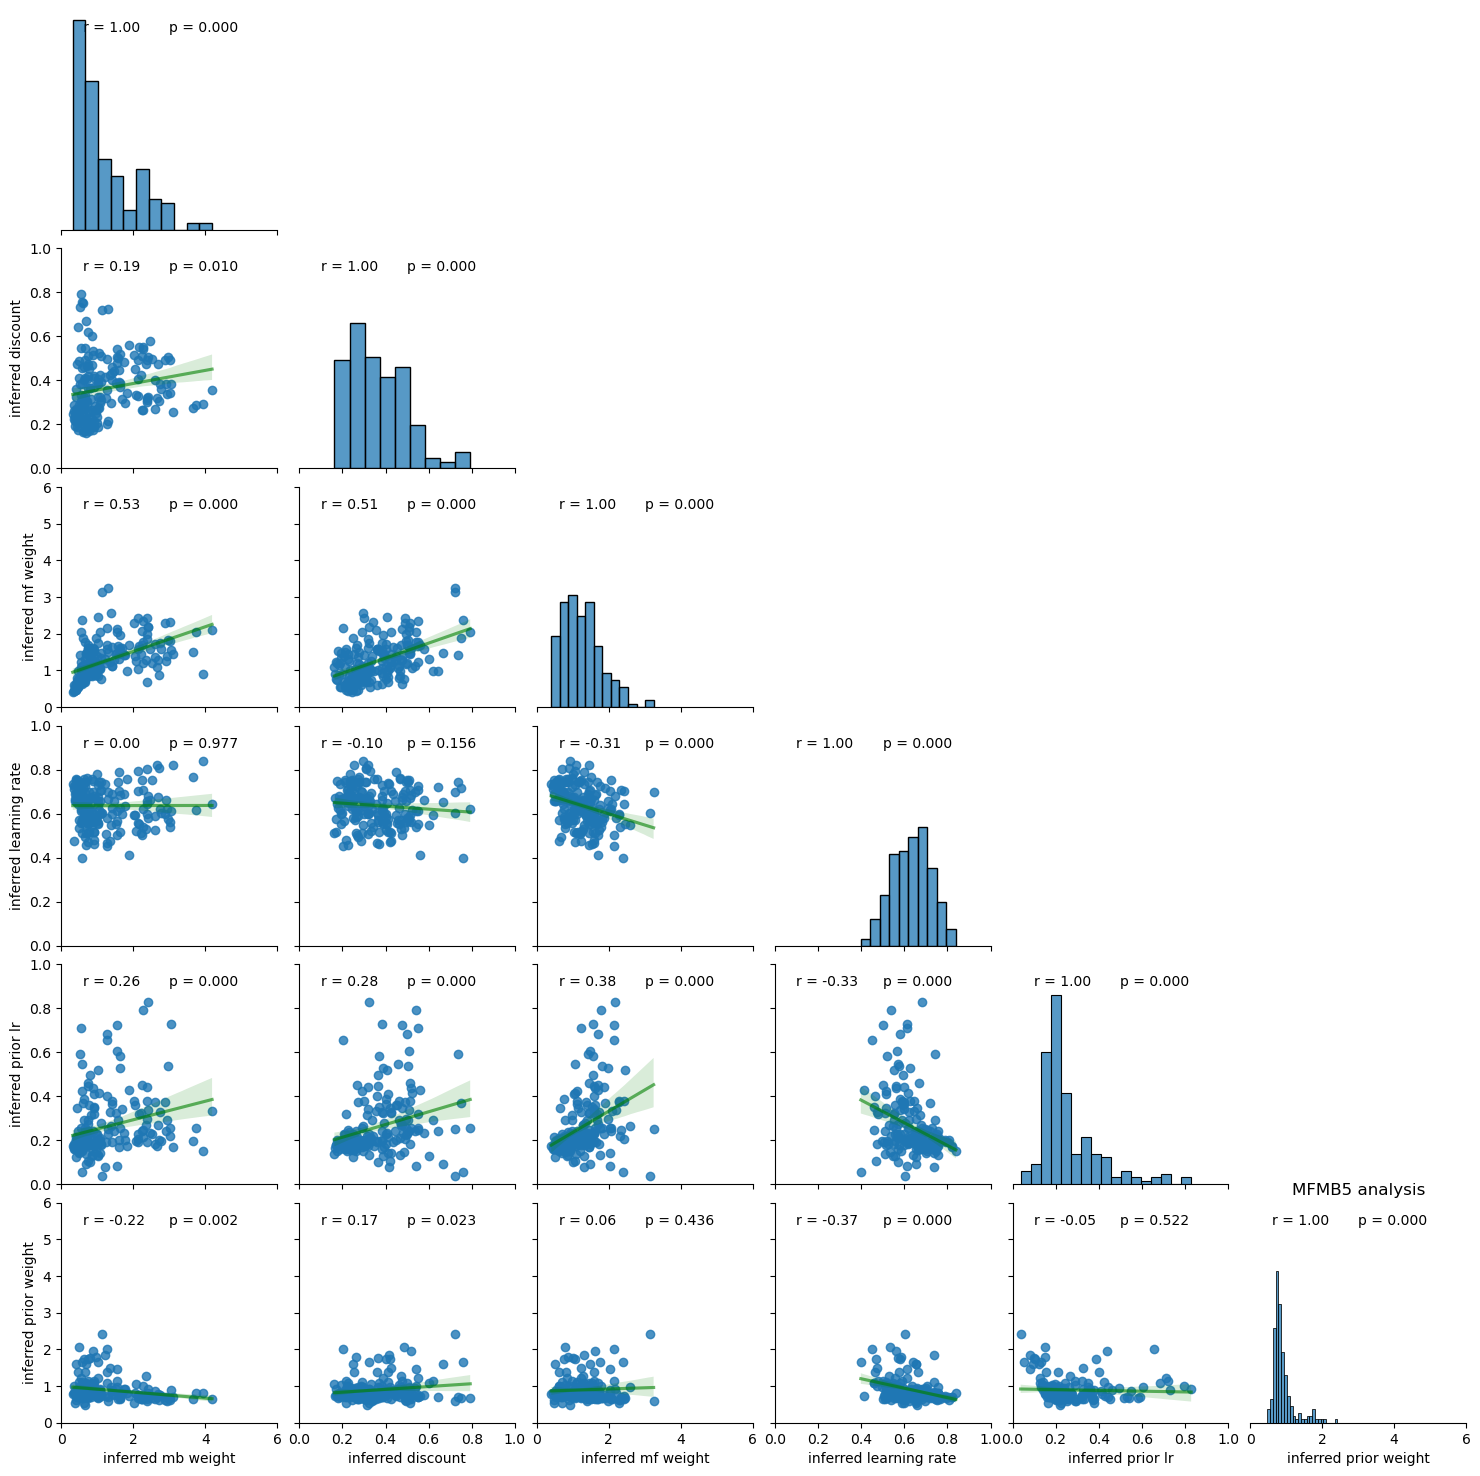

This is inference for the twostage task using the two beta mbmf model(mbmf__prior) with 188 agents.
The settings are: use p False


In [20]:
# MFMB6 analysis

# set parameters and their names
learn_prior = True

use_orig = False

use_p = False
restrict_alpha = False
max_dt = 6

n_pars = 4

agnt_str = ""

if use_orig:
    agnt_str += "mbmfOrig_"
    param_names = ["discount", "learning rate", "dec temp", "weight"]
    model_name = "original original w and beta model"
    param_ranges = [[0,1], [0,1], [0,8], [0,1]]
else:
    agnt_str += "mbmf_"
    param_names = ["mb weight", "discount", "mf weight", "learning rate"]
    model_name = "two beta mbmf model"
    param_ranges = [[0,max_dt], [0,1], [0,max_dt], [0,1]]


if learn_prior:
    n_pars += 2
    param_names += ["prior lr", "prior weight"]
    param_ranges += [[0,1], [0,max_dt]]
    agnt_str += "_prior"

if use_p:
    n_pars += 1
    agnt_str += "_p"
    param_names += ["repetition"]
    
if restrict_alpha:
    agnt_str += "_resticted"
    min_alpha = 0.1
else:
    min_alpha = 0

# prepare for saving results
# make base filename and folder string
agent_type = agnt_str

MFMB6_param_names = param_names.copy()
MFMB6_param_ranges = param_ranges.copy()

# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

num_steps = 600

MFMB6_mean_df, MFMB6_sample_df, MFMB6_locs_df = load_MFMB_results(use_orig, learn_prior, use_p, restrict_alpha, max_dt, base_dir, global_experiment_parameters, data["valid"], fname_base, num_steps, data, MFMB6_param_names)

plt.figure()
vars_of_interest = ["inferred "+name for name in MFMB6_param_names]
f = sns.pairplot(data=MFMB6_mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(MFMB6_param_ranges):
    f.axes[n_pars-1,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")
print("The settings are: use p", use_p)

### MFMB6: plot correlations with behavioral outputs: mf-/mb-scores

['inferred mb weight MFMB6', 'inferred discount MFMB6', 'inferred mf weight MFMB6', 'inferred learning rate MFMB6', 'inferred prior lr MFMB6', 'inferred prior weight MFMB6']


<Figure size 640x480 with 0 Axes>

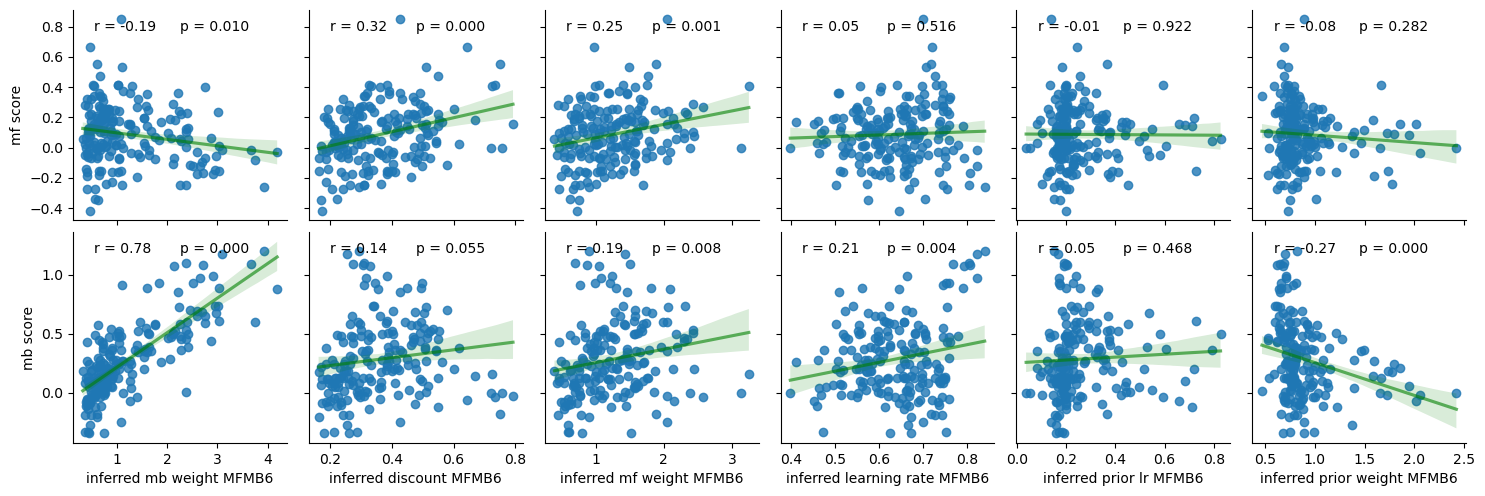

In [21]:
# MFMB4

concat_keys_MFMB6 = [name+" MFMB6" for name in MFMB6_mean_df.keys()]

new_name_dict_MFMB6 = {MFMB6_mean_df.keys()[i]: concat_keys_MFMB6[i] for i in range(len(concat_keys_MFMB6))}

renamed_MFMB6 = MFMB6_mean_df.rename(columns=new_name_dict_MFMB6)

MFMB6_scores_df = pd.concat([renamed_MFMB6, scores_df], axis='columns')#, join="inner")

plt.figure()
x_vars_of_interest = ["inferred "+name+" MFMB6" for name in MFMB6_param_names]
print(x_vars_of_interest)
y_vars_of_interest = ["mf score", "mb score"]
f = sns.pairplot(data=MFMB6_scores_df, kind='reg', #diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    x_vars=x_vars_of_interest, y_vars=y_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[2,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("BCC3 analysis 1 correlations with scores")
plt.savefig(os.path.join(results_folder, "MFMB6_correlations_with_scores.svg"))
plt.show()

### Sanity check: did the MFMB4 and MFMB6 analyses yield consistent results in the parameters they share?

Plotting correlations between inferred parameters of the two analyses

Index(['Unnamed: 0 MFMB4', 'inferred mb weight MFMB4', 'subject MFMB4',
       'inferred discount MFMB4', 'inferred mf weight MFMB4',
       'inferred learning rate MFMB4', 'Unnamed: 0 MFMB6',
       'inferred mb weight MFMB6', 'subject MFMB6', 'inferred discount MFMB6',
       'inferred mf weight MFMB6', 'inferred learning rate MFMB6',
       'inferred prior lr MFMB6', 'inferred prior weight MFMB6'],
      dtype='object')
['Unnamed: 0 MFMB4', 'inferred mb weight MFMB4', 'subject MFMB4', 'inferred discount MFMB4', 'inferred mf weight MFMB4', 'inferred learning rate MFMB4']
['Unnamed: 0 MFMB6', 'inferred mb weight MFMB6', 'subject MFMB6', 'inferred discount MFMB6', 'inferred mf weight MFMB6', 'inferred learning rate MFMB6', 'inferred prior lr MFMB6', 'inferred prior weight MFMB6']
Index(['Unnamed: 0 MFMB4', 'inferred mb weight MFMB4', 'subject MFMB4',
       'inferred discount MFMB4', 'inferred mf weight MFMB4',
       'inferred learning rate MFMB4'],
      dtype='object')


<Figure size 640x480 with 0 Axes>

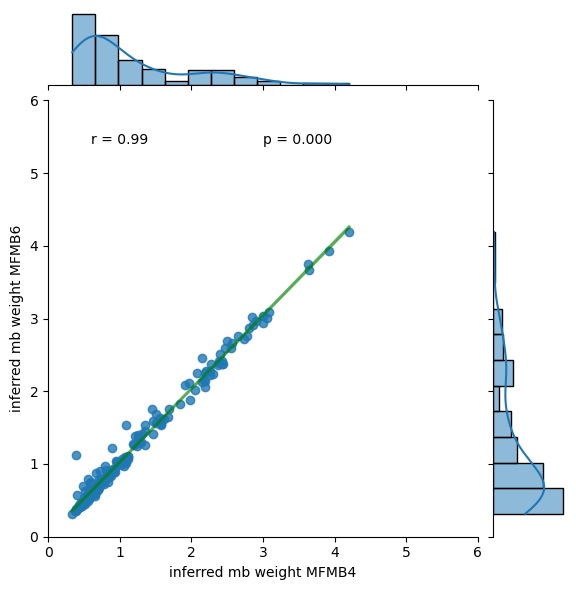

<Figure size 640x480 with 0 Axes>

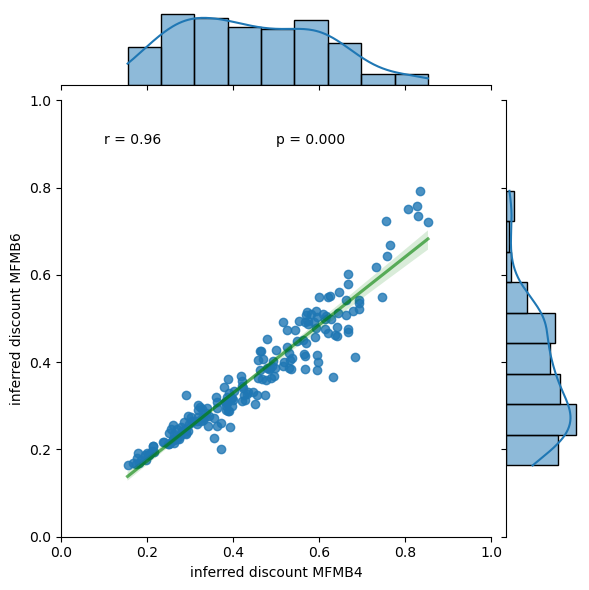

<Figure size 640x480 with 0 Axes>

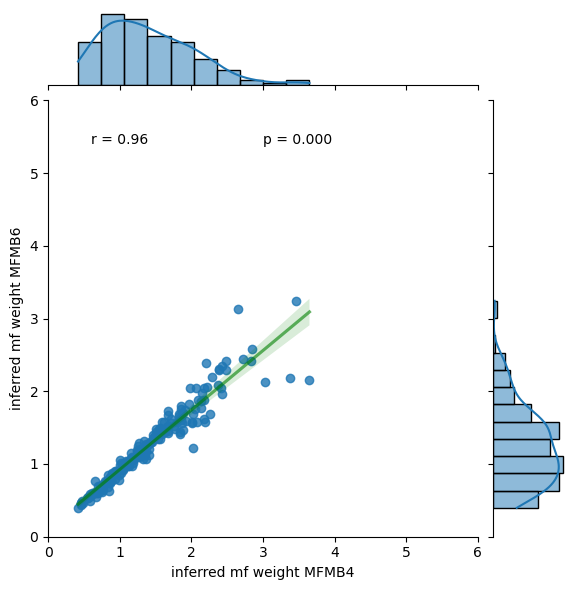

<Figure size 640x480 with 0 Axes>

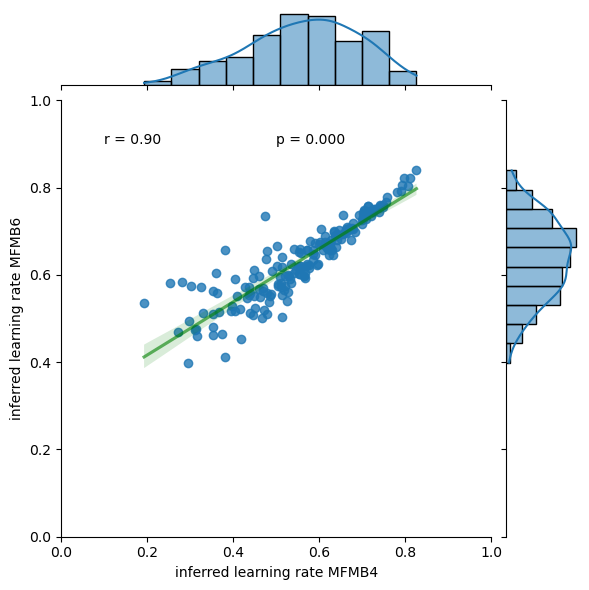

In [22]:
# compare the two results

concat_keys_MFMB4 = [name+" MFMB4" for name in MFMB4_mean_df.keys()]
concat_keys_MFMB6 = [name+" MFMB6" for name in MFMB6_mean_df.keys()]

new_name_dict_MFMB4 = {MFMB4_mean_df.keys()[i]: concat_keys_MFMB4[i] for i in range(len(concat_keys_MFMB4))}
new_name_dict_MFMB5 = {MFMB6_mean_df.keys()[i]: concat_keys_MFMB6[i] for i in range(len(concat_keys_MFMB6))}

renamed_MFMB4 = MFMB4_mean_df.rename(columns=new_name_dict_MFMB4)
renamed_MFMB5 = MFMB6_mean_df.rename(columns=new_name_dict_MFMB5)

MFMB_means_df = pd.concat([renamed_MFMB4, renamed_MFMB5], axis='columns')#, join="inner")

print(MFMB_means_df.keys())

print(concat_keys_MFMB4)
print(concat_keys_MFMB6)
print(renamed_MFMB4.keys())

for i, name in enumerate(MFMB4_param_names):
    plt.figure()
    sns.jointplot(data=MFMB_means_df, x="inferred "+name+" MFMB4", y="inferred "+name+" MFMB6", 
                  kind='reg', joint_kws={'line_kws': {'color': 'green', 'alpha': 0.6}})
    tu.annot_corrfunc(MFMB_means_df["inferred "+name+" MFMB4"], MFMB_means_df["inferred "+name+" MFMB6"])
    plt.xlim(MFMB4_param_ranges[i])
    plt.ylim(MFMB4_param_ranges[i])
    plt.show()

### Compare inferences between the BCC and MFMB models:

using the BCC4 planning+repetition and the MFMB4 model for the comparison

Index(['Unnamed: 0 BCC4_p_r', 'inferred dec temp BCC4_p_r', 'subject BCC4_p_r',
       'inferred reward rate BCC4_p_r', 'inferred habitual tendency BCC4_p_r',
       'inferred policy rate BCC4_p_r', 'Unnamed: 0 MFMB4',
       'inferred mb weight MFMB4', 'subject MFMB4', 'inferred discount MFMB4',
       'inferred mf weight MFMB4', 'inferred learning rate MFMB4'],
      dtype='object')
['inferred dec temp BCC4_p_r', 'inferred reward rate BCC4_p_r', 'inferred habitual tendency BCC4_p_r', 'inferred policy rate BCC4_p_r']
['inferred mb weight MFMB4', 'inferred discount MFMB4', 'inferred mf weight MFMB4', 'inferred learning rate MFMB4']


<Figure size 640x480 with 0 Axes>

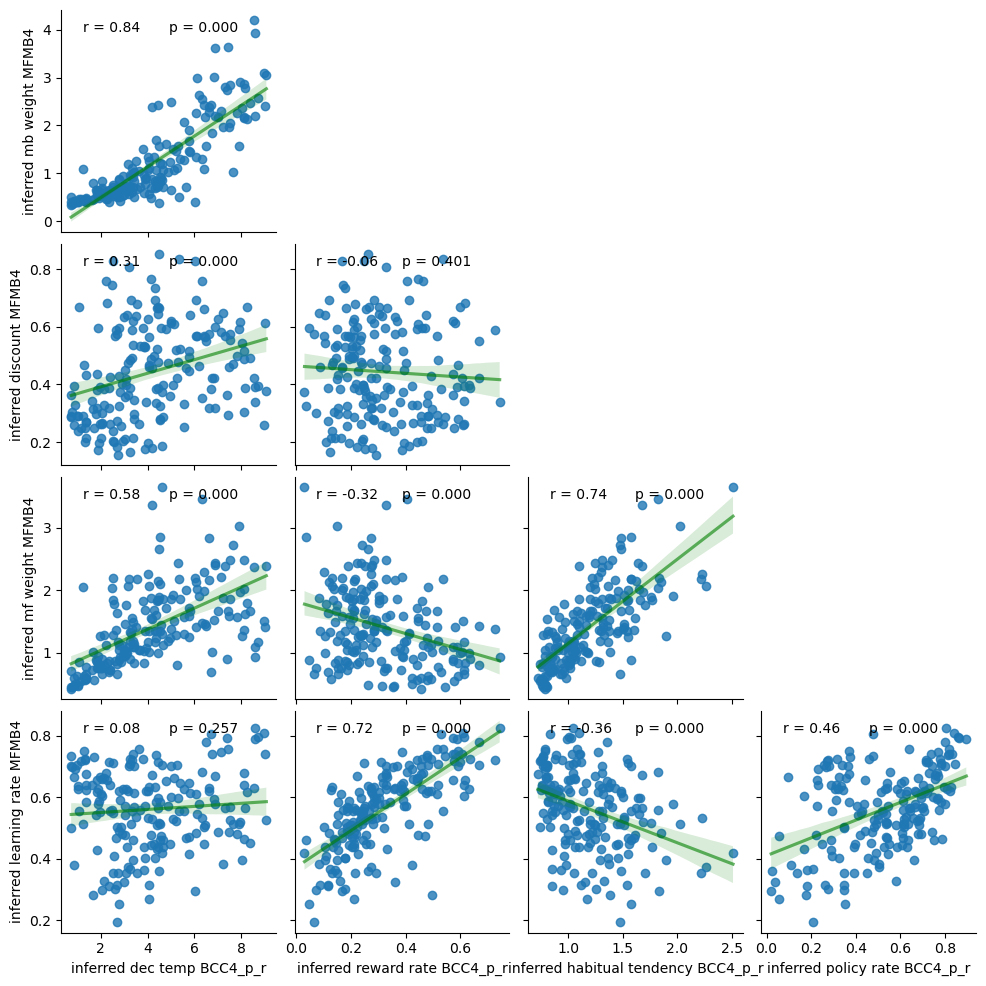

In [23]:
# compare BCC and MBMF4 results

BCC4_p_r_MBMF4_means_df = pd.concat([renamed_BCC4_p_r, renamed_MFMB4], axis='columns')#, join="inner")

print(BCC4_p_r_MBMF4_means_df.keys())

y_vars_of_interest = ["inferred "+name+" MFMB4" for name in MFMB4_param_names]
x_vars_of_interest = ["inferred "+name+" BCC4_p_r" for name in BCC4_p_r_param_names]

print(x_vars_of_interest)
print(y_vars_of_interest)

plt.figure()
f = sns.pairplot(data=BCC4_p_r_MBMF4_means_df, kind='reg', corner=True,#, diag_kind="hist"
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    y_vars=y_vars_of_interest,
                    x_vars=x_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[3,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        

using the BCC4 planning+cached and the MFMB4 model for the comparison

Index(['Unnamed: 0 BCC4_p_c', 'inferred dec temp BCC4_p_c', 'subject BCC4_p_c',
       'inferred reward rate BCC4_p_c', 'inferred cached weight BCC4_p_c',
       'inferred cached rate BCC4_p_c', 'Unnamed: 0 MFMB4',
       'inferred mb weight MFMB4', 'subject MFMB4', 'inferred discount MFMB4',
       'inferred mf weight MFMB4', 'inferred learning rate MFMB4'],
      dtype='object')
['inferred dec temp BCC4_p_c', 'inferred reward rate BCC4_p_c', 'inferred cached weight BCC4_p_c', 'inferred cached rate BCC4_p_c']
['inferred mb weight MFMB4', 'inferred discount MFMB4', 'inferred mf weight MFMB4', 'inferred learning rate MFMB4']


<Figure size 640x480 with 0 Axes>

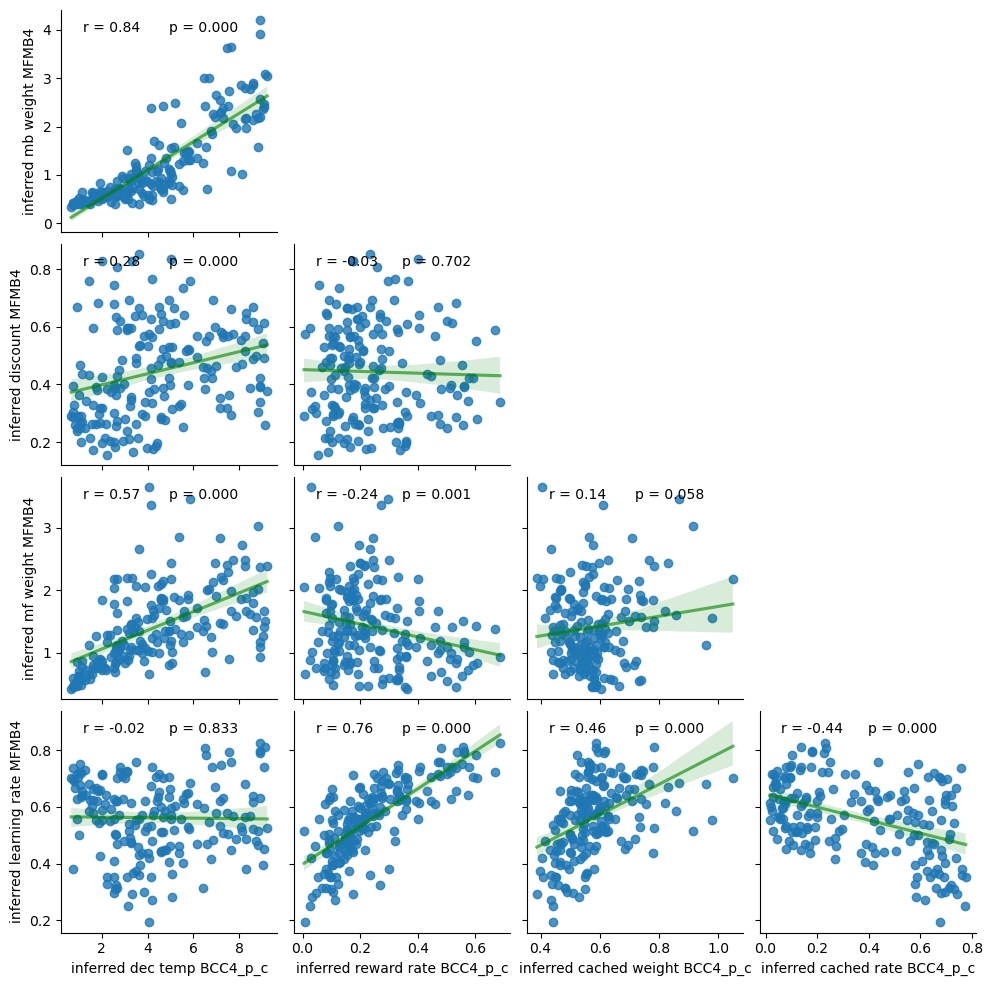

In [24]:
# compare BCC and MBMF4 results

BCC4_p_c_MBMF4_means_df = pd.concat([renamed_BCC4_p_c, renamed_MFMB4], axis='columns')#, join="inner")

print(BCC4_p_c_MBMF4_means_df.keys())

y_vars_of_interest = ["inferred "+name+" MFMB4" for name in MFMB4_param_names]
x_vars_of_interest = ["inferred "+name+" BCC4_p_c" for name in BCC4_p_c_param_names]

print(x_vars_of_interest)
print(y_vars_of_interest)

plt.figure()
f = sns.pairplot(data=BCC4_p_c_MBMF4_means_df, kind='reg', corner=True,#, diag_kind="hist"
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    y_vars=y_vars_of_interest,
                    x_vars=x_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[3,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        

using the BCC6 planning+cached and the MFMB4 model for the comparison

Index(['Unnamed: 0 BCC6', 'inferred dec temp BCC6', 'subject BCC6',
       'inferred reward rate BCC6', 'inferred habitual tendency BCC6',
       'inferred policy rate BCC6', 'inferred cached weight BCC6',
       'inferred cached rate BCC6', 'Unnamed: 0 MFMB4',
       'inferred mb weight MFMB4', 'subject MFMB4', 'inferred discount MFMB4',
       'inferred mf weight MFMB4', 'inferred learning rate MFMB4'],
      dtype='object')
['inferred dec temp BCC6', 'inferred reward rate BCC6', 'inferred habitual tendency BCC6', 'inferred policy rate BCC6', 'inferred cached weight BCC6', 'inferred cached rate BCC6']
['inferred mb weight MFMB4', 'inferred discount MFMB4', 'inferred mf weight MFMB4', 'inferred learning rate MFMB4']


<Figure size 640x480 with 0 Axes>

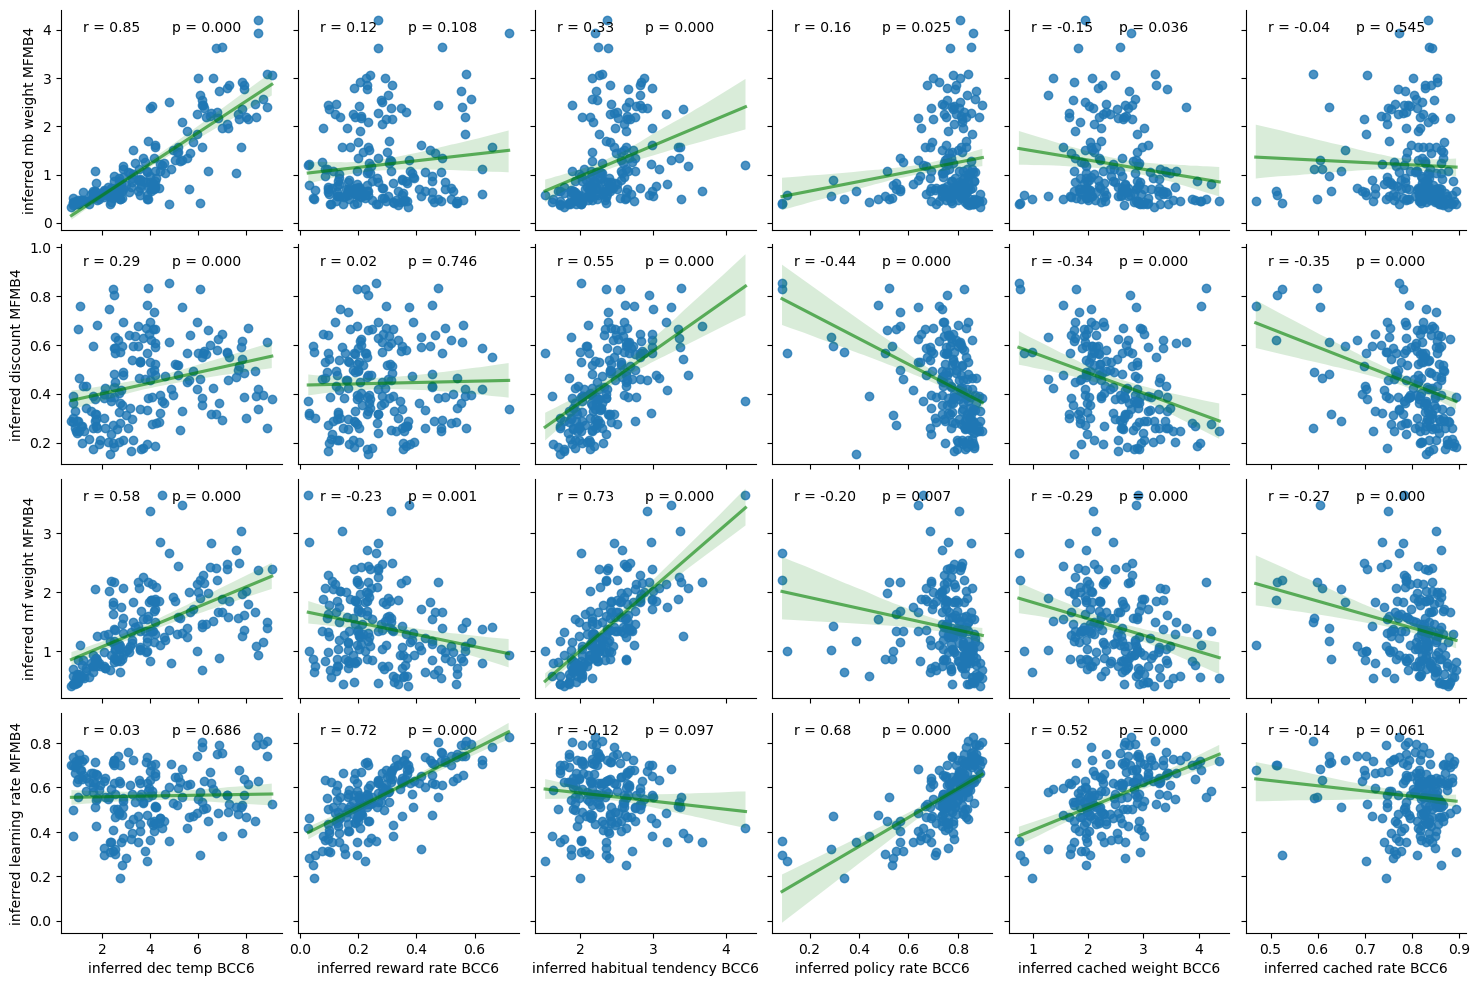

In [25]:
# compare BCC and MBMF4 results

BCC6_MBMF4_means_df = pd.concat([renamed_BCC6, renamed_MFMB4], axis='columns')#, join="inner")

print(BCC6_MBMF4_means_df.keys())

y_vars_of_interest = ["inferred "+name+" MFMB4" for name in MFMB4_param_names]
x_vars_of_interest = ["inferred "+name+" BCC6" for name in BCC6_param_names]

print(x_vars_of_interest)
print(y_vars_of_interest)

plt.figure()
f = sns.pairplot(data=BCC6_MBMF4_means_df, kind='reg',# corner=True,#, diag_kind="hist"
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    y_vars=y_vars_of_interest,
                    x_vars=x_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[3,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        

### Compare inferences between the BCC and MFMB models:

using the BCC4 planning+repetition and the MFMB6 model for the comparison

Index(['Unnamed: 0 BCC4_p_r', 'inferred dec temp BCC4_p_r', 'subject BCC4_p_r',
       'inferred reward rate BCC4_p_r', 'inferred habitual tendency BCC4_p_r',
       'inferred policy rate BCC4_p_r', 'Unnamed: 0 MFMB6',
       'inferred mb weight MFMB6', 'subject MFMB6', 'inferred discount MFMB6',
       'inferred mf weight MFMB6', 'inferred learning rate MFMB6',
       'inferred prior lr MFMB6', 'inferred prior weight MFMB6'],
      dtype='object')
['inferred dec temp BCC4_p_r', 'inferred reward rate BCC4_p_r', 'inferred habitual tendency BCC4_p_r', 'inferred policy rate BCC4_p_r']
['inferred mb weight MFMB6', 'inferred discount MFMB6', 'inferred mf weight MFMB6', 'inferred learning rate MFMB6', 'inferred prior lr MFMB6', 'inferred prior weight MFMB6']


<Figure size 640x480 with 0 Axes>

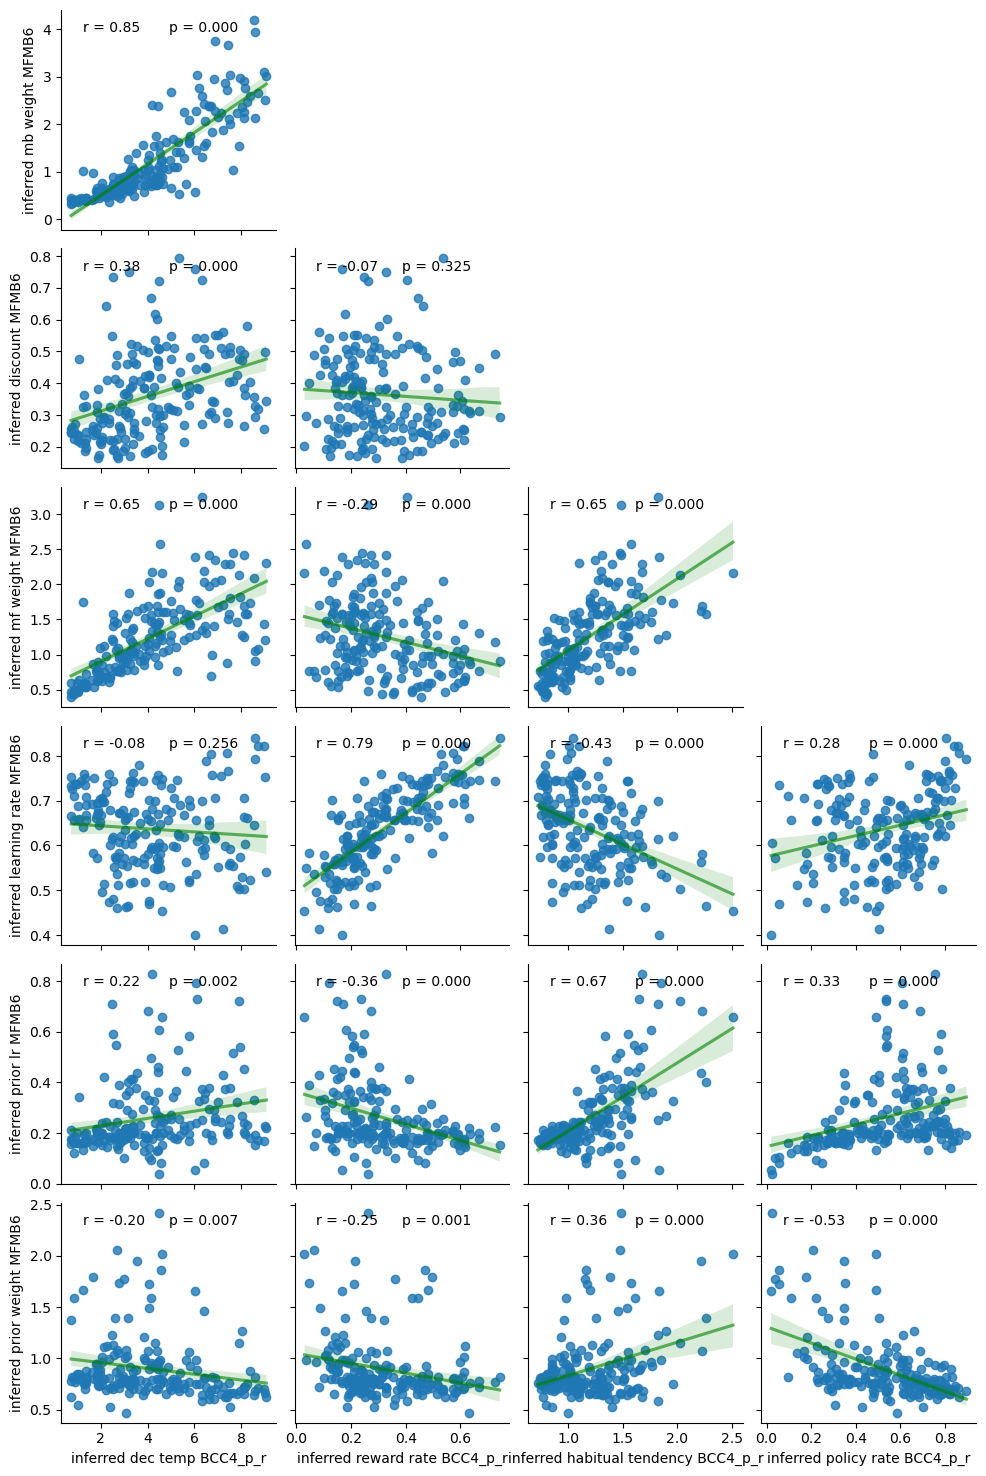

In [26]:
# compare BCC and MBMF4 results

BCC4_p_r_MBMF6_means_df = pd.concat([renamed_BCC4_p_r, renamed_MFMB6], axis='columns')#, join="inner")

print(BCC4_p_r_MBMF6_means_df.keys())

y_vars_of_interest = ["inferred "+name+" MFMB6" for name in MFMB6_param_names]
x_vars_of_interest = ["inferred "+name+" BCC4_p_r" for name in BCC4_p_r_param_names]

print(x_vars_of_interest)
print(y_vars_of_interest)

plt.figure()
f = sns.pairplot(data=BCC4_p_r_MBMF6_means_df, kind='reg', corner=True,#, diag_kind="hist"
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    y_vars=y_vars_of_interest,
                    x_vars=x_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[3,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        

using the BCC4 planning+cached and the MFMB6 model for the comparison

Index(['Unnamed: 0 BCC4_p_c', 'inferred dec temp BCC4_p_c', 'subject BCC4_p_c',
       'inferred reward rate BCC4_p_c', 'inferred cached weight BCC4_p_c',
       'inferred cached rate BCC4_p_c', 'Unnamed: 0 MFMB6',
       'inferred mb weight MFMB6', 'subject MFMB6', 'inferred discount MFMB6',
       'inferred mf weight MFMB6', 'inferred learning rate MFMB6',
       'inferred prior lr MFMB6', 'inferred prior weight MFMB6'],
      dtype='object')
['inferred dec temp BCC4_p_c', 'inferred reward rate BCC4_p_c', 'inferred cached weight BCC4_p_c', 'inferred cached rate BCC4_p_c']
['inferred mb weight MFMB6', 'inferred discount MFMB6', 'inferred mf weight MFMB6', 'inferred learning rate MFMB6', 'inferred prior lr MFMB6', 'inferred prior weight MFMB6']


<Figure size 640x480 with 0 Axes>

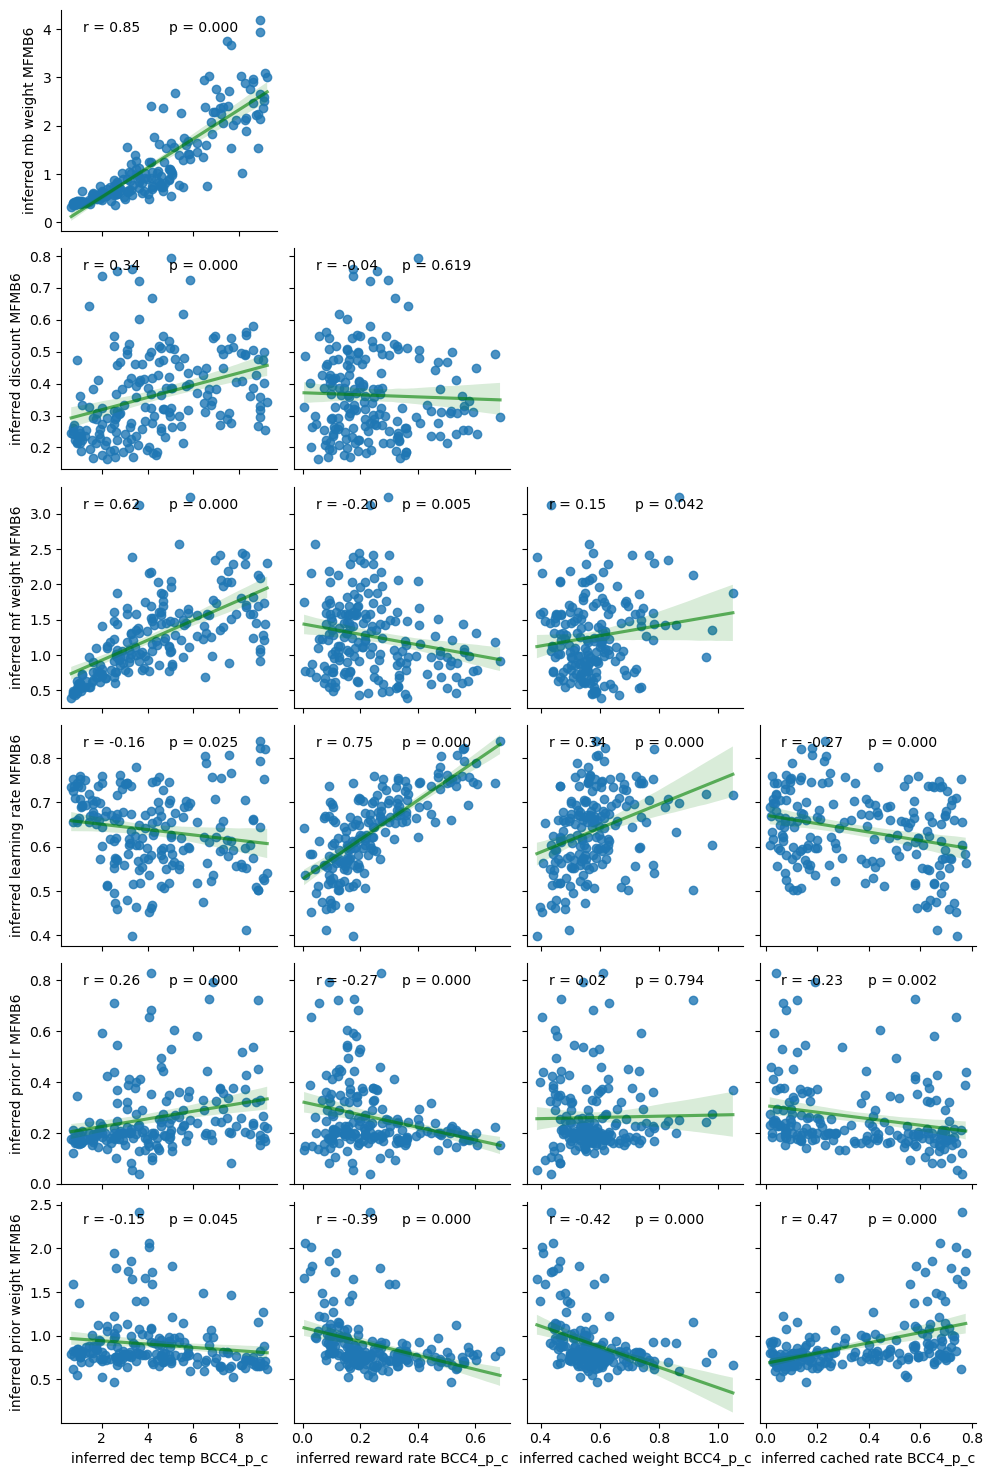

In [27]:
# compare BCC and MBMF4 results

BCC4_p_c_MBMF6_means_df = pd.concat([renamed_BCC4_p_c, renamed_MFMB6], axis='columns')#, join="inner")

print(BCC4_p_c_MBMF6_means_df.keys())

y_vars_of_interest = ["inferred "+name+" MFMB6" for name in MFMB6_param_names]
x_vars_of_interest = ["inferred "+name+" BCC4_p_c" for name in BCC4_p_c_param_names]

print(x_vars_of_interest)
print(y_vars_of_interest)

plt.figure()
f = sns.pairplot(data=BCC4_p_c_MBMF6_means_df, kind='reg', corner=True,#, diag_kind="hist"
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    y_vars=y_vars_of_interest,
                    x_vars=x_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[3,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        

using the BCC6 planning+cached and the MFMB6 model for the comparison

Index(['Unnamed: 0 BCC6', 'inferred dec temp BCC6', 'subject BCC6',
       'inferred reward rate BCC6', 'inferred habitual tendency BCC6',
       'inferred policy rate BCC6', 'inferred cached weight BCC6',
       'inferred cached rate BCC6', 'Unnamed: 0 MFMB6',
       'inferred mb weight MFMB6', 'subject MFMB6', 'inferred discount MFMB6',
       'inferred mf weight MFMB6', 'inferred learning rate MFMB6',
       'inferred prior lr MFMB6', 'inferred prior weight MFMB6'],
      dtype='object')
['inferred dec temp BCC6', 'inferred reward rate BCC6', 'inferred habitual tendency BCC6', 'inferred policy rate BCC6', 'inferred cached weight BCC6', 'inferred cached rate BCC6']
['inferred mb weight MFMB6', 'inferred discount MFMB6', 'inferred mf weight MFMB6', 'inferred learning rate MFMB6', 'inferred prior lr MFMB6', 'inferred prior weight MFMB6']


<Figure size 640x480 with 0 Axes>

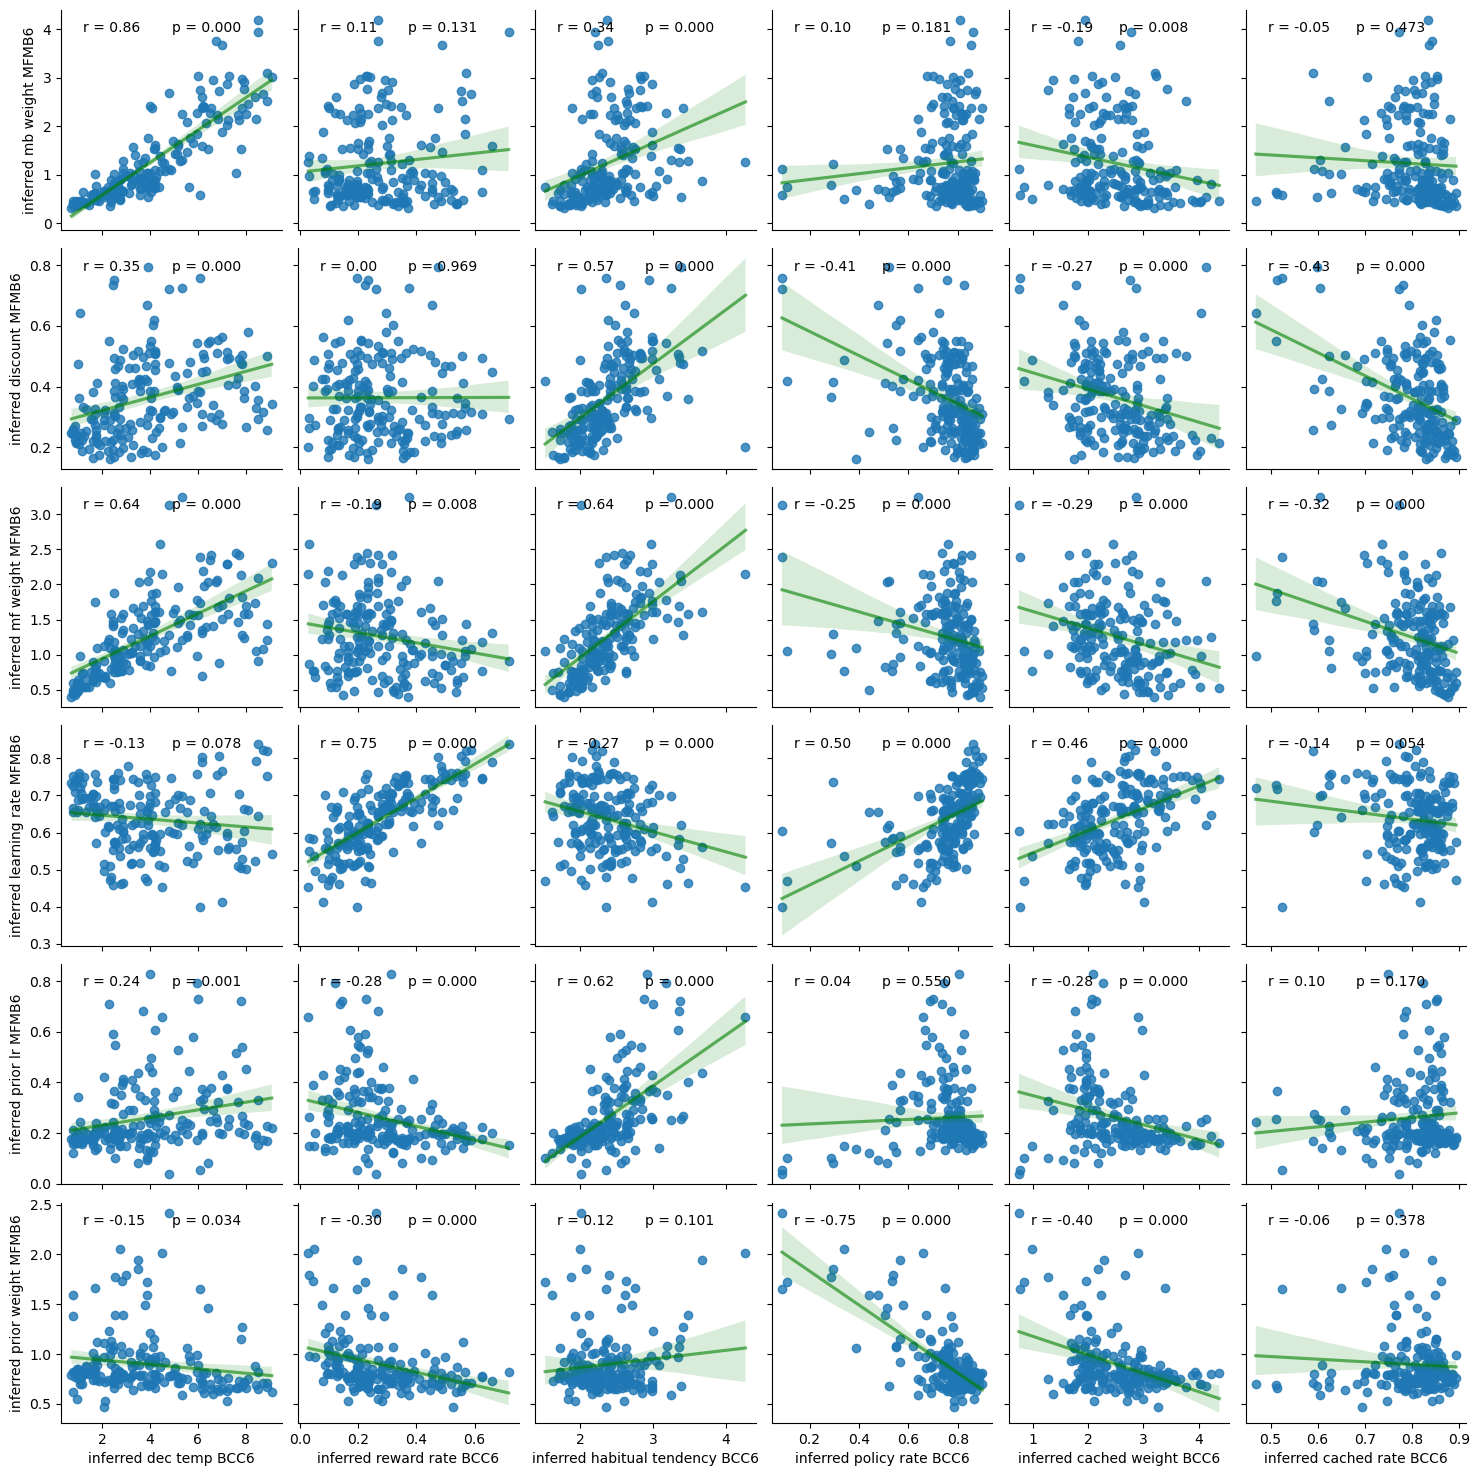

In [28]:
# compare BCC and MBMF4 results

BCC6_MBMF6_means_df = pd.concat([renamed_BCC6, renamed_MFMB6], axis='columns')#, join="inner")

print(BCC6_MBMF6_means_df.keys())

y_vars_of_interest = ["inferred "+name+" MFMB6" for name in MFMB6_param_names]
x_vars_of_interest = ["inferred "+name+" BCC6" for name in BCC6_param_names]

print(x_vars_of_interest)
print(y_vars_of_interest)

plt.figure()
f = sns.pairplot(data=BCC6_MBMF6_means_df, kind='reg',# corner=True,#, diag_kind="hist"
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    y_vars=y_vars_of_interest,
                    x_vars=x_vars_of_interest)
f.map(tu.annot_corrfunc)
#for p, p_range in enumerate(param_plot_ranges):
#    f.axes[3,p].set_xlim(p_range)
#    f.axes[p,0].set_ylim(p_range)
#plt.title("MFMB5 analysis")
#plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        